In [1]:
print("Jai Mata Di")

Jai Mata Di


In [3]:
# Required Libraries
import os
import sys
import time
import datetime
import pandas as pd
import numpy as np
# import neurokit2 as nk
import matplotlib.pyplot as plt
import glob

import random
random.seed(42)

In [4]:
# List all CSV files in the BPM directory
bpm_files = os.path.join(r'/home/aditya22040/start/adi_god_2/HyperaktivNEW/cropped_bpm_data_FINAL_sequence_Manual_cleaning_spl_back', '*.csv')
# print("BPM files:", bpm_files)
activity_files = os.path.join(r'/home/aditya22040/start/adi_god_2/HyperaktivNEW/cropped_activity_data_FINAL_sequence_Manual_cleaning_spl_back', '*.csv')

# Read kro csv 
bpm_files = glob.glob(bpm_files)
activity_files = glob.glob(activity_files)

# print(activity_files)
# Now change the column name of BPM file HRV to IBI 

# for i in range(len(bpm_files)):
#     print("BPM File:", bpm_files[i])
#     print("Activity File:", activity_files[i])
#     bpm_df = pd.read_csv(bpm_files[i])
#     activity_df = pd.read_csv(activity_files[i])
    
#     # Rename the column name
#     bpm_df.rename(columns = {'HRV':'IBI'}, inplace = True)
    
#     # Save the file
#     bpm_df.to_csv(bpm_files[i], index=False)
#     activity_df.to_csv(activity_files[i], index=False)
    
#     print("Done")
#     print("===============================================")

# was needed once only to change the column name from HRV to IBI now successfully done so commenting it out

# finding the name of the file 
def file_name(file,activity_files = False):
    if activity_files:
        return int(file.split('_')[-1].split('.')[0])  # Extract ID from filename
    else:
        return int(file.split('_')[-2])  # Extract ID from filename

from pandas import DataFrame
def give_binned_data(df:DataFrame, patient_id:int, bin_size:int = 5)->DataFrame:
    df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
    df.set_index('TIMESTAMP', inplace=True)
    
    # Get the first timestamp to use as origin
    origin = df.index[0]
    
    # Calculate both mean and std for each bin with specific origin
    mean_df = df.resample(f'{bin_size}T', origin=origin).mean()
    std_df = df.resample(f'{bin_size}T', origin=origin).std()
    
    # Rename std columns
    std_df.columns = [col + '_STD' for col in std_df.columns]
    
    # Combine mean and std DataFrames
    df = pd.concat([mean_df, std_df], axis=1)
    df = df.reset_index()
    
    # Add a bin number column
    df['Bin'] = range(1, len(df) + 1)
    df['Patient ID'] = df.apply(lambda row: f"{patient_id}_{int(row['Bin'])}", axis=1)
    df = df.drop('Bin', axis=1)
    
    return df

In [5]:
# Read the patient info CSV with only needed columns
target_df = pd.read_csv(r'/home/aditya22040/start/adi_god_2/googledrive-archive/patient_info.csv', delimiter=';', usecols=['ID', 'ADHD'])

# Rename ID column to match with Patient ID in bpm_df
target_df = target_df.rename(columns={'ID': 'Patient ID'})

# Display the target dataset
print("Target Dataset:")
print(target_df.head())
print("\nShape of target dataset:", target_df.shape)
for i in range(0, 30):
    print(target_df['Patient ID'][i],end=" ")
    print(target_df['ADHD'][i])
    print("\n")

Target Dataset:
   Patient ID  ADHD
0           1     1
1           2     1
2           3     1
3           4     1
4           5     1

Shape of target dataset: (103, 2)
1 1


2 1


3 1


4 1


5 1


7 0


8 1


9 0


10 0


11 1


12 1


13 1


14 1


15 0


16 0


17 0


18 0


19 1


20 1


21 1


22 0


23 0


24 0


25 0


26 1


27 0


28 0


29 1


30 0


31 0




In [6]:
main_activity_df = pd.DataFrame()   

for file in activity_files:
    patient_id = file_name(file,True)  # Extract ID from filename
    df = pd.read_csv(file)
    df = give_binned_data(df,patient_id,2)
    # print(df.head()).
    # exit(0)
    target = target_df[target_df['Patient ID'] == patient_id]['ADHD'].values[0]
    df['ADHD'] = target
    main_activity_df = pd.concat([main_activity_df,df],ignore_index=True)
# lets make another df to store the data without binning

activity_ka_data = pd.DataFrame()
for file in activity_files:
    patient_id = file_name(file,True)  # Extract ID from filename
    df = pd.read_csv(file)
    df['Patient ID'] = patient_id
    target = target_df[target_df['Patient ID'] == patient_id]['ADHD'].values[0]
    df['ADHD'] = target
    activity_ka_data = pd.concat([activity_ka_data, df], ignore_index=True)

# Display the activity dataset
print("Activity Dataset:")
print(activity_ka_data.head())
print("\nShape of activity dataset:", activity_ka_data.shape)



Activity Dataset:
             TIMESTAMP  ACTIVITY  Patient ID  ADHD
0  2010-08-27 11:25:00        40          78     0
1  2010-08-27 11:26:00       372          78     0
2  2010-08-27 11:27:00        10          78     0
3  2010-08-27 11:28:00       756          78     0
4  2010-08-27 11:29:00       709          78     0

Shape of activity dataset: (61346, 4)


In [7]:
from hrvanalysis.hrvanalysis.preprocessing import (
    remove_outliers,
    interpolate_nan_values,
    remove_ectopic_beats,
    
)
from hrvanalysis.hrvanalysis.extract_features import (
    get_time_domain_features, 
    get_frequency_domain_features
)

# from hrvanalysis import get_time_domain_features, get_frequency_domain_features

def bin_spl_for_bpm_no_outliers(df: pd.DataFrame, bin_size: int = 5) -> pd.DataFrame:
    """
    Processes the dataframe to calculate HRV metrics without outlier removal after skipping the first minute.
    """
    # Convert timestamp to datetime
    df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
    
    # Skip first minute
    start_time = df['TIMESTAMP'].min() + pd.Timedelta(minutes=1)
    df = df[df['TIMESTAMP'] >= start_time]
    
    df.set_index('TIMESTAMP', inplace=True)

    # Resample data into bins starting after the first minute
    binned_data = []
    for timestamp, group in df.resample(f'{bin_size}T', origin=start_time):
        if group.empty or 'IBI' not in group.columns or group['IBI'].dropna().empty:
            continue

        ibi_array = group['IBI'].dropna().values

        # Process NN intervals without outlier removal
        try:
            if len(ibi_array) < 2:
                continue
            nn_intervals = interpolate_nan_values(rr_intervals=ibi_array, interpolation_method="linear")
            if len(nn_intervals) < 2:
                continue
        except Exception as e:
            continue
        hr_mean = group['BPM'].mean()
        # Extract HRV Features
        time_domain_features = get_time_domain_features(nn_intervals)
        freq_domain_features = get_frequency_domain_features(nn_intervals, method="welch")
        nn50_count = np.sum(np.abs(np.diff(nn_intervals)) > 50)
        pnn50 = nn50_count / len(nn_intervals) * 100

        bin_features = {
            'TIMESTAMP': timestamp,
            'SDNN': time_domain_features.get('sdnn', np.nan),
            'RMSSD': time_domain_features.get('rmssd', np.nan),
            'NN50': nn50_count / len(nn_intervals),
            'pNN50': pnn50,
            'LF': freq_domain_features.get('lf', np.nan),
            'HF': freq_domain_features.get('hf', np.nan),
            'LF/HF': freq_domain_features.get('lf_hf_ratio', np.nan),
            "HR" : hr_mean
        }

        binned_data.append(bin_features)

    if not binned_data:
        return pd.DataFrame()

    binned_df = pd.DataFrame(binned_data)
    binned_df.reset_index(drop=True, inplace=True)
    return binned_df

bpm_tmp_data = pd.DataFrame()
for file in bpm_files:
    patient_id = file_name(file)
    df = pd.read_csv(file)
    df['Patient ID'] = patient_id
    df_binned = bin_spl_for_bpm_no_outliers(df, 2)
    
    if not df_binned.empty:
        df_binned['Patient ID'] = df_binned.apply(lambda row: f"{patient_id}_{row.name + 1}", axis=1)
        target = target_df[target_df['Patient ID'] == patient_id]['ADHD'].values[0]
        df_binned['ADHD'] = target
        bpm_tmp_data = pd.concat([bpm_tmp_data, df_binned], ignore_index=True)
    else:
        print(f"Skipping {file} as no valid bins found.")

print("\nBPM Temporary Dataset:")
print(bpm_tmp_data.shape)




/home/aditya22040/.local/lib/python3.8/site-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 256 is greater than input length  = 109, using nperseg = 109
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/aditya22040/.local/lib/python3.8/site-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 256 is greater than input length  = 222, using nperseg = 222
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/aditya22040/.local/lib/python3.8/site-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 256 is greater than input length  = 216, using nperseg = 216
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/aditya22040/.local/lib/python3.8/site-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 256 is greater than input length  = 166, using nperseg = 166
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/aditya22040/.local/lib/python3.8/site-packages/sci


BPM Temporary Dataset:
(29911, 11)


/home/aditya22040/.local/lib/python3.8/site-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 256 is greater than input length  = 29, using nperseg = 29
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/aditya22040/.local/lib/python3.8/site-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 256 is greater than input length  = 36, using nperseg = 36
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/aditya22040/.local/lib/python3.8/site-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 256 is greater than input length  = 35, using nperseg = 35
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/aditya22040/.local/lib/python3.8/site-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 256 is greater than input length  = 28, using nperseg = 28
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/aditya22040/.local/lib/python3.8/site-packages/scipy/signa

In [9]:
print(bpm_tmp_data.head())
bpm_tmp_data
print(bpm_tmp_data.value_counts('ADHD'))


            TIMESTAMP        SDNN       RMSSD      NN50      pNN50  \
0 2011-05-10 13:26:00  444.153734  597.513382  0.909091  90.909091   
1 2011-05-10 13:28:00  386.078612  404.633790  0.892562  89.256198   
2 2011-05-10 13:30:00  217.616512  260.541108  0.779736  77.973568   
3 2011-05-10 13:32:00  255.477075  266.829954  0.755319  75.531915   
4 2011-05-10 13:34:00  397.891795  557.818309  0.800000  80.000000   

              LF            HF     LF/HF          HR Patient ID  ADHD  
0  115381.217692  40082.491822  2.878594   50.807493      105_1     0  
1   32134.805042  25634.354121  1.253584   90.250871      105_2     0  
2   12621.426478  11511.540684  1.096415  133.205272      105_3     0  
3   12625.239056   8321.417383  1.517198  137.033827      105_4     0  
4   33763.783792  17982.641651  1.877576   39.708439      105_5     0  
ADHD
0    15558
1    14353
Name: count, dtype: int64


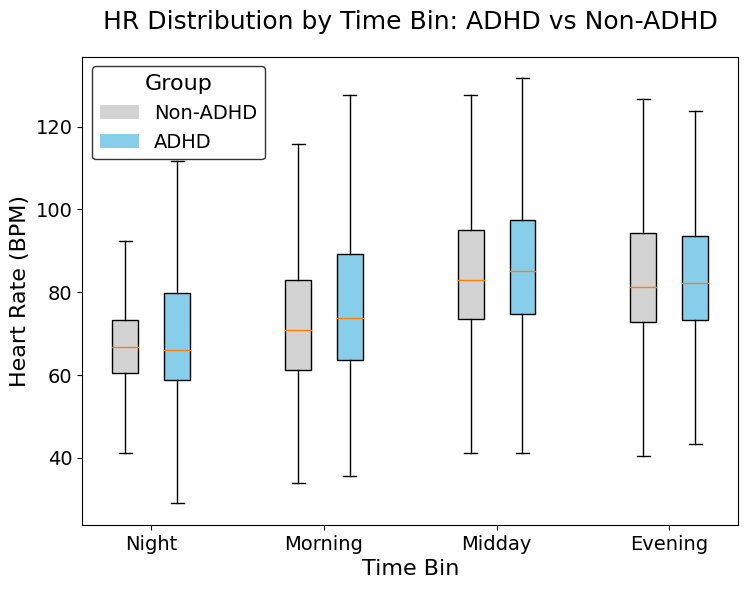

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Assume bpm_tmp_data is already in memory
df = bpm_tmp_data.copy()

# Parse timestamps & assign bins (as before)…
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
def assign_bin(t):
    if t >= pd.to_datetime('00:00:00').time() and t < pd.to_datetime('06:00:00').time():
        return 'Night'
    elif t >= pd.to_datetime('06:00:00').time() and t < pd.to_datetime('12:00:00').time():
        return 'Morning'
    elif t >= pd.to_datetime('12:00:00').time() and t < pd.to_datetime('18:00:00').time():
        return 'Midday'
    else:
        return 'Evening'
df['time_bin'] = df['TIMESTAMP'].dt.time.apply(assign_bin)

# Prepare data and positions
bins = ['Night','Morning','Midday','Evening']
colors = {0: 'lightgray', 1: 'skyblue'}

data, pos, facecol = [], [], []
for i, tb in enumerate(bins):
    for label in (0, 1):  # 0 = non-ADHD, 1 = ADHD
        hr_vals = df.loc[(df['time_bin']==tb) & (df['ADHD']==label), 'HR']
        data.append(hr_vals)
        base = i * 2
        offset = -0.3 if label==0 else +0.3
        pos.append(base + 1 + offset)
        facecol.append(colors[label])
fig, ax = plt.subplots(figsize=(8,6))   # <<< reduced width from 12→8
bp = ax.boxplot(
    data,
    positions=pos,
    widths=0.3,
    patch_artist=True,
    showfliers=False
)

# color boxes (as before)…
for patch, fc in zip(bp['boxes'], facecol):
    patch.set_facecolor(fc)

# labels, ticks, title (same fontsize tweaks)…
ax.set_xticks([i*2+1 for i in range(len(bins))])
ax.set_xticklabels(bins, fontsize=14)
ax.set_xlabel('Time Bin', fontsize=16)
ax.set_ylabel('Heart Rate (BPM)', fontsize=16)
ax.set_title('HR Distribution by Time Bin: ADHD vs Non-ADHD', fontsize=18, pad=20)
ax.tick_params(axis='y', labelsize=14)

# tighten the subplot to remove extra white space
fig.subplots_adjust(left=0.15, right=0.97, top=0.90, bottom=0.12)

# legend inside upper‐left
legend_patches = [
    Patch(facecolor=colors[0], label='Non-ADHD'),
    Patch(facecolor=colors[1], label='ADHD')
]
ax.legend(handles=legend_patches,
          title='Group',
          fontsize=14,
          title_fontsize=16,
          loc='upper left',
          frameon=True,
          edgecolor='black')

plt.show()
main_activity_df.dropna(inplace=True)
bpm_tmp_data.dropna(inplace=True)

In [11]:
import pandas as pd

# Create copies of the data to avoid modifying the originals
bpm_tmp_data_copy = bpm_tmp_data.copy()
main_activity_df_copy = main_activity_df.copy()

# Print initial shapes and data types
print("bpm_data", bpm_tmp_data_copy.shape)
print(bpm_tmp_data_copy['Patient ID'].dtype)
print(main_activity_df_copy['Patient ID'].dtype)
print(main_activity_df_copy.shape)

# Convert Patient ID to string and extract part before underscore
bpm_tmp_data_copy['Patient ID'] = bpm_tmp_data_copy['Patient ID'].astype(str).str.split('_').str[0]
main_activity_df_copy['Patient ID'] = main_activity_df_copy['Patient ID'].astype(str).str.split('_').str[0]

# Floor timestamps to the nearest minute
bpm_tmp_data_copy['TIMESTAMP'] = bpm_tmp_data_copy['TIMESTAMP'].dt.floor('T')
main_activity_df_copy['TIMESTAMP'] = main_activity_df_copy['TIMESTAMP'].dt.floor('T')

# Create a mask to filter records
mask = main_activity_df_copy[['Patient ID', 'TIMESTAMP']].apply(tuple, axis=1).isin(
    bpm_tmp_data_copy[['Patient ID', 'TIMESTAMP']].apply(tuple, axis=1)
)

# Apply the mask to filter the data
filtered_main_activity_df = main_activity_df_copy[mask]

print("\nFiltered Main Activity Dataset:")
print(filtered_main_activity_df.shape)
print(filtered_main_activity_df.head())

# Check for duplicates and missing values
print("Duplicates in bpm_data:", bpm_tmp_data_copy.duplicated(['Patient ID', 'TIMESTAMP']).sum())
print("Duplicates in main_activity_df:", main_activity_df_copy.duplicated(['Patient ID', 'TIMESTAMP']).sum())
print("Missing in bpm_data:", bpm_tmp_data_copy.isnull().sum())
print("Missing in main_activity_df:", main_activity_df_copy.isnull().sum())


bpm_data (29911, 11)
object
object
(30685, 5)

Filtered Main Activity Dataset:
(29911, 5)
            TIMESTAMP  ACTIVITY  ACTIVITY_STD Patient ID  ADHD
0 2010-08-27 11:25:00     206.0    234.759451         78     0
1 2010-08-27 11:27:00     383.0    527.501659         78     0
2 2010-08-27 11:29:00     354.5    501.338708         78     0
3 2010-08-27 11:31:00     352.0    357.796031         78     0
4 2010-08-27 11:33:00     737.0   1033.790114         78     0
Duplicates in bpm_data: 0
Duplicates in main_activity_df: 0
Missing in bpm_data: TIMESTAMP     0
SDNN          0
RMSSD         0
NN50          0
pNN50         0
LF            0
HF            0
LF/HF         1
HR            0
Patient ID    0
ADHD          0
dtype: int64
Missing in main_activity_df: TIMESTAMP        0
ACTIVITY         0
ACTIVITY_STD    24
Patient ID       0
ADHD             0
dtype: int64


## For Time checking 

In [12]:
# Ensure TIMESTAMP is in datetime format
bpm_tmp_data_copy['TIMESTAMP'] = pd.to_datetime(bpm_tmp_data_copy['TIMESTAMP'])

# Group by 'Patient ID' and find min and max timestamps
time_data = bpm_tmp_data_copy.groupby(['Patient ID', 'ADHD'])['TIMESTAMP'].agg(['min', 'max']).reset_index()

# Calculate total hours for each patient
time_data['Total Hours'] = (time_data['max'] - time_data['min']).dt.total_seconds() / 3600

print("\nTime Data:")
print(time_data.shape)
print(time_data)

# Calculate total hours for ADHD and Non-ADHD
adhd_hours = time_data[time_data['ADHD'] == 1]['Total Hours'].sum()
non_adhd_hours = time_data[time_data['ADHD'] == 0]['Total Hours'].sum()

print(f"Total hours for ADHD students: {adhd_hours:.2f} hours")
print(f"Total hours for Non-ADHD students: {non_adhd_hours:.2f} hours")



Time Data:
(50, 5)
   Patient ID  ADHD                 min                 max  Total Hours
0         101     0 2011-05-02 14:31:00 2011-05-03 11:51:00    21.333333
1         104     0 2011-04-15 12:08:00 2011-04-16 10:12:00    22.066667
2         105     0 2011-05-10 13:26:00 2011-05-11 02:52:00    13.433333
3          11     1 2009-04-23 12:01:00 2009-04-23 18:17:00     6.266667
4          19     1 2009-06-29 11:01:00 2009-06-29 20:49:00     9.800000
5          20     1 2009-06-23 15:01:00 2009-06-24 14:17:00    23.266667
6          22     0 2009-06-16 16:56:00 2009-06-17 17:00:00    24.066667
7          23     0 2009-08-17 11:01:00 2009-08-18 10:53:00    23.866667
8          27     0 2009-08-11 11:46:00 2009-08-12 05:52:00    18.100000
9          32     0 2009-10-09 10:01:00 2009-10-10 10:47:00    24.766667
10         33     0 2009-10-08 10:47:00 2009-10-09 14:23:00    27.600000
11         34     0 2009-10-14 14:32:00 2009-10-15 12:54:00    22.366667
12         35     0 2009-10-14 

In [13]:
bpm_spl_data = bpm_tmp_data.copy()
main_activity_df = filtered_main_activity_df.copy()
print(main_activity_df.shape,bpm_spl_data.shape)
# makin a new column time_new_temp that will save binary 0 for day and 1 for night and that would be simply done by checking the hour of the day 

# Day time is 6:01 to 17:59 and night time is 18:00 to 6:00
main_activity_df['TIMESTAMP'] = pd.to_datetime(main_activity_df['TIMESTAMP'])

# assigning 0 or 1

def time_assigner(time):
    if time.hour >= 6 and time.hour < 18:
        return 1
    else:
        return 0

main_activity_df['time_new_temp'] = main_activity_df['TIMESTAMP'].apply(time_assigner)

# print(main_activity_df['time_new_temp'])

print("Activity Dataset:")
print(main_activity_df.head())

(29911, 5) (29911, 11)
Activity Dataset:
            TIMESTAMP  ACTIVITY  ACTIVITY_STD Patient ID  ADHD  time_new_temp
0 2010-08-27 11:25:00     206.0    234.759451         78     0              1
1 2010-08-27 11:27:00     383.0    527.501659         78     0              1
2 2010-08-27 11:29:00     354.5    501.338708         78     0              1
3 2010-08-27 11:31:00     352.0    357.796031         78     0              1
4 2010-08-27 11:33:00     737.0   1033.790114         78     0              1


In [14]:
# similarly for bpm ka data

bpm_spl_data['TIMESTAMP'] = pd.to_datetime(bpm_spl_data['TIMESTAMP'])

bpm_spl_data['time_new_temp'] = bpm_spl_data['TIMESTAMP'].apply(time_assigner)

print("BPM Dataset:")
print(bpm_spl_data.head())


BPM Dataset:
            TIMESTAMP        SDNN       RMSSD      NN50      pNN50  \
0 2011-05-10 13:26:00  444.153734  597.513382  0.909091  90.909091   
1 2011-05-10 13:28:00  386.078612  404.633790  0.892562  89.256198   
2 2011-05-10 13:30:00  217.616512  260.541108  0.779736  77.973568   
3 2011-05-10 13:32:00  255.477075  266.829954  0.755319  75.531915   
4 2011-05-10 13:34:00  397.891795  557.818309  0.800000  80.000000   

              LF            HF     LF/HF          HR Patient ID  ADHD  \
0  115381.217692  40082.491822  2.878594   50.807493      105_1     0   
1   32134.805042  25634.354121  1.253584   90.250871      105_2     0   
2   12621.426478  11511.540684  1.096415  133.205272      105_3     0   
3   12625.239056   8321.417383  1.517198  137.033827      105_4     0   
4   33763.783792  17982.641651  1.877576   39.708439      105_5     0   

   time_new_temp  
0              1  
1              1  
2              1  
3              1  
4              1  


In [15]:
chat = ['ACTIVITY__variance_larger_than_standard_deviation',
       'ACTIVITY__number_peaks__n_1', 'ACTIVITY__number_peaks__n_5',
       'ACTIVITY__number_peaks__n_3', 'ACTIVITY__binned_entropy__max_bins_10',"TIMESTAMP"]
# Read the activity features CSV file and handle any potential issues
try:
    activity_features = pd.read_csv("/home/aditya22040/start/adi_god_2/HyperaktivNEW/activity_features_2min.csv", index_col=None)
    
    print("Shape of loaded activity features:", activity_features.shape)
    print("\nSample of loaded features:")
    print(activity_features.head())
except FileNotFoundError:
    print("Error: activity_features.csv file not found")
except Exception as e:
    print(f"Error loading activity features: {e}")

Shape of loaded activity features: (30685, 784)

Sample of loaded features:
   ACTIVITY__variance_larger_than_standard_deviation  \
0                                                1.0   
1                                                1.0   
2                                                0.0   
3                                                0.0   
4                                                0.0   

   ACTIVITY__has_duplicate_max  ACTIVITY__has_duplicate_min  \
0                          0.0                          0.0   
1                          0.0                          0.0   
2                          1.0                          1.0   
3                          1.0                          1.0   
4                          1.0                          1.0   

   ACTIVITY__has_duplicate  ACTIVITY__sum_values  ACTIVITY__abs_energy  \
0                      0.0                 515.0              149357.0   
1                      0.0                 434.0            

In [16]:
# 1. Create a copy of the original dataset
modified_df = activity_ka_data.copy()

# 2. Modify the 'Patient ID' column by removing everything after the first underscore
# modified_df['Patient ID'] = modified_df['Patient ID'].str.split('_').str[0]

# Check the first few rows of the modified dataset
print(modified_df.head(10))

             TIMESTAMP  ACTIVITY  Patient ID  ADHD
0  2010-08-27 11:25:00        40          78     0
1  2010-08-27 11:26:00       372          78     0
2  2010-08-27 11:27:00        10          78     0
3  2010-08-27 11:28:00       756          78     0
4  2010-08-27 11:29:00       709          78     0
5  2010-08-27 11:30:00         0          78     0
6  2010-08-27 11:31:00       605          78     0
7  2010-08-27 11:32:00        99          78     0
8  2010-08-27 11:33:00         6          78     0
9  2010-08-27 11:34:00      1468          78     0


In [20]:
import pandas as pd

def update_patient_ids(df, window_size=5):
    """
    Update patient IDs by adding window numbers based on a specified window size, starting from 1
    
    Args:
        df: pandas DataFrame containing the data
        window_size: size of each window in minutes (default=5)
    
    Returns:
        DataFrame with updated Patient IDs
    """
    df = df.copy()
    df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])  # Ensure TIMESTAMP is datetime

    # Sort by Patient ID and TIMESTAMP to ensure correct grouping
    df = df.sort_values(['Patient ID', 'TIMESTAMP'])

    # Compute window numbers for each patient
    def process_patient(group):
        start_time = group['TIMESTAMP'].min()
        group['Window'] = ((group['TIMESTAMP'] - start_time).dt.total_seconds() // (window_size * 60)).astype(int) + 1  # Start from 1
        group['Patient ID'] = group['Patient ID'].astype(str) + "_" + group['Window'].astype(str)
        return group
    
    # Apply the function to each patient separately
    df = df.groupby('Patient ID', group_keys=False).apply(process_patient)

    return df.drop(columns=['Window'])  # Remove auxiliary column before returning


updated_df = update_patient_ids(modified_df,2)
# print(len(updated_df["Patient ID"]))
k = updated_df["Patient ID"]
qp = set()
for i in k:
    qp.add(i)

print(len(qp))
# Convert qp set to DataFrame with Patient ID column
qp_df = pd.DataFrame(sorted(list(qp)), columns=['Patient ID'])
# qp_df
print(activity_features.shape)
print(qp_df.shape)  
print("Activity features shape:", activity_features.shape)
print("Patient ID DataFrame shape:", qp_df.shape)

# Merge the extracted features with the Patient ID DataFrame
activity_features = pd.merge(qp_df, activity_features, left_index=True, right_index=True, how='inner')
activity_features = pd.merge(qp_df, activity_features, on='Patient ID', how='left')

30685
(30685, 784)
(30685, 1)
Activity features shape: (30685, 784)
Patient ID DataFrame shape: (30685, 1)


In [21]:
import pandas as pd

# Assuming both dataframes have 'Patient ID' and 'TIMESTAMP' columns
# activity_features -> contains extra entries
# bpm_spl_data -> contains the correct TIMESTAMP and Patient ID

# 1. Perform an inner merge to keep only matching Patient IDs
merged_df = activity_features.merge(bpm_spl_data[['Patient ID', 'TIMESTAMP']], on='Patient ID', how='inner')

# 2. Replace the TIMESTAMP in activity_features with the matched TIMESTAMP from bpm_spl_data
activity_features = merged_df.copy()

# 3. Display the result
print(activity_features.head())


  Patient ID  ACTIVITY__variance_larger_than_standard_deviation  \
0      101_1                                                1.0   
1     101_10                                                1.0   
2    101_100                                                0.0   
3    101_101                                                0.0   
4    101_102                                                0.0   

   ACTIVITY__has_duplicate_max  ACTIVITY__has_duplicate_min  \
0                          0.0                          0.0   
1                          0.0                          0.0   
2                          1.0                          1.0   
3                          1.0                          1.0   
4                          1.0                          1.0   

   ACTIVITY__has_duplicate  ACTIVITY__sum_values  ACTIVITY__abs_energy  \
0                      0.0                 515.0              149357.0   
1                      0.0                 434.0              168676.0

In [22]:
# Select required columns from activity_features including Patient ID
required_columns = ['Patient ID'] + chat  # Add 'Patient ID' and exclude 'TIMESTAMP'
activity_features_tmp = activity_features[required_columns]
temp_df = main_activity_df[['Patient ID', 'TIMESTAMP']]
activity_features_tmp['Patient ID'] = activity_features_tmp['Patient ID'].str.split('_').str[0]
# Standardize both DataFrames to remove microseconds
temp_df['TIMESTAMP'] = pd.to_datetime(temp_df['TIMESTAMP'].dt.strftime('%Y-%m-%d %H:%M:%S'))
activity_features_tmp['TIMESTAMP'] = pd.to_datetime(activity_features_tmp['TIMESTAMP'].dt.strftime('%Y-%m-%d %H:%M:%S'))

temp_df
# # Select required columns from activity_features including Patient ID
# required_columns = ['Patient ID'] + chat  # Add 'Patient ID' and exclude 'TIMESTAMP'
# activity_features_tmp = activity_features[required_columns]
# activity_features_tmp['Patient ID'] = activity_features_tmp['Patient ID'].str.split('_').str[0]
# # Create a temporary DataFrame with just Patient ID and TIMESTAMP from main_activity_df
# temp_df = main_activity_df[['Patient ID', 'TIMESTAMP']]

final_activity_features = pd.merge(temp_df, activity_features_tmp, 
                                   on=['Patient ID','TIMESTAMP'],  
                                   how='left')  # ✅ Add missing comma

print(final_activity_features.isna().sum())
# # Reorder columns to match the chat list order
# final_columns = chat+["Patient ID"]  # This includes all columns including TIMESTAMP
# activity_features_tmp = final_activity_features[final_columns]
activity_features_tmp['time_new_temp'] = activity_features_tmp['TIMESTAMP'].apply(time_assigner)

Patient ID                                              0
TIMESTAMP                                               0
ACTIVITY__variance_larger_than_standard_deviation    1742
ACTIVITY__number_peaks__n_1                          1742
ACTIVITY__number_peaks__n_5                          1742
ACTIVITY__number_peaks__n_3                          1742
ACTIVITY__binned_entropy__max_bins_10                1742
dtype: int64


/tmp/ipykernel_3645202/1951676759.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  activity_features_tmp['Patient ID'] = activity_features_tmp['Patient ID'].str.split('_').str[0]
/tmp/ipykernel_3645202/1951676759.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['TIMESTAMP'] = pd.to_datetime(temp_df['TIMESTAMP'].dt.strftime('%Y-%m-%d %H:%M:%S'))
/tmp/ipykernel_3645202/1951676759.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [23]:
# Find timestamps in main_activity_df that are missing in activity_features_tmp
missing_timestamps = temp_df[~temp_df['TIMESTAMP'].isin(activity_features_tmp['TIMESTAMP'])]
print("Missing Timestamps:")
print(missing_timestamps.head(10))
print("Total missing:", len(missing_timestamps))


Missing Timestamps:
  Patient ID           TIMESTAMP
0         78 2010-08-27 11:25:00
1         78 2010-08-27 11:27:00
2         78 2010-08-27 11:29:00
3         78 2010-08-27 11:31:00
4         78 2010-08-27 11:33:00
5         78 2010-08-27 11:35:00
6         78 2010-08-27 11:37:00
7         78 2010-08-27 11:39:00
8         78 2010-08-27 11:41:00
9         78 2010-08-27 11:43:00
Total missing: 1742


In [24]:
print("Final Activity Features:")
print(activity_features_tmp.head())
print("\nShape of final activity features:", activity_features_tmp.shape)

Final Activity Features:
  Patient ID  ACTIVITY__variance_larger_than_standard_deviation  \
0        101                                                1.0   
1        101                                                1.0   
2        101                                                0.0   
3        101                                                0.0   
4        101                                                0.0   

   ACTIVITY__number_peaks__n_1  ACTIVITY__number_peaks__n_5  \
0                          0.0                          0.0   
1                          0.0                          0.0   
2                          0.0                          0.0   
3                          0.0                          0.0   
4                          0.0                          0.0   

   ACTIVITY__number_peaks__n_3  ACTIVITY__binned_entropy__max_bins_10  \
0                          0.0                               0.693147   
1                          0.0                 

In [25]:
from sklearn.model_selection import train_test_split
def split_by_patients(df, test_size=0.4, random_state=42):
    # Get unique patient IDs (before _bin_number)
    patient_ids = df['Patient ID'].apply(lambda x: x.split('_')[0]).unique()
    
    # Split patient IDs into train/test
    train_patients, test_patients = train_test_split(
        patient_ids, 
        test_size=test_size, 
        random_state=random_state
    )
    
    # Split data based on patient IDs
    train_mask = df['Patient ID'].apply(lambda x: x.split('_')[0]).isin(train_patients)
    train_df = df[train_mask]
    test_df = df[~train_mask]
    
    return train_df, test_df

         SDNN       RMSSD      NN50      pNN50             LF            HF  \
0  444.153734  597.513382  0.909091  90.909091  115381.217692  40082.491822   
1  386.078612  404.633790  0.892562  89.256198   32134.805042  25634.354121   
2  217.616512  260.541108  0.779736  77.973568   12621.426478  11511.540684   
3  255.477075  266.829954  0.755319  75.531915   12625.239056   8321.417383   
4  397.891795  557.818309  0.800000  80.000000   33763.783792  17982.641651   

   time_new_temp     LF/HF  
0              1  2.878594  
1              1  1.253584  
2              1  1.096415  
3              1  1.517198  
4              1  1.877576  
Activity Data (SGD) Results:
Accuracy: 0.4211840228245364

Classification Report:
              precision    recall  f1-score   support

         0.0       0.42      1.00      0.59      4724
         1.0       0.00      0.00      0.00      6492

    accuracy                           0.42     11216
   macro avg       0.21      0.50      0.30     112

/home/aditya22040/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aditya22040/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aditya22040/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


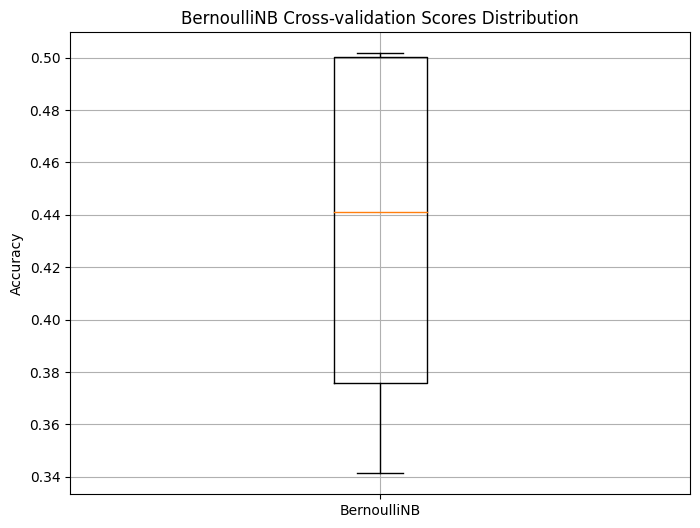

In [26]:
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
# Prepare activity data
activity_features = ['ACTIVITY__variance_larger_than_standard_deviation',
                    'ACTIVITY__number_peaks__n_1',
                    'ACTIVITY__number_peaks__n_5',
                    'ACTIVITY__number_peaks__n_3',
                    'ACTIVITY__binned_entropy__max_bins_10',"time_new_temp"]

# Create feature matrices
activity_data = activity_features_tmp[activity_features + ['Patient ID']]
activity_data['ADHD'] = main_activity_df['ADHD']

bpm_features = ['SDNN', 'RMSSD', 'NN50', 'pNN50', 'LF', 'HF',"time_new_temp","LF/HF"]
bpm_data = bpm_spl_data[bpm_features + ['Patient ID', 'ADHD']]
bpm_data = bpm_data.dropna()    
# Split data by patients
activity_data.fillna(0, inplace=True)
bpm_data.fillna(0, inplace=True)

activity_train, activity_test = split_by_patients(activity_data)
bpm_train, bpm_test = split_by_patients(bpm_data)

# Separate features and labels
X_activity_train = activity_train[activity_features]
y_activity_train = activity_train['ADHD']
X_activity_test = activity_test[activity_features]
y_activity_test = activity_test['ADHD']

X_bpm_train = bpm_train[bpm_features]
y_bpm_train = bpm_train['ADHD']
X_bpm_test = bpm_test[bpm_features]
y_bpm_test = bpm_test['ADHD']


scaler_activity = StandardScaler()
X_activity_train_scaled = scaler_activity.fit_transform(X_activity_train)
X_activity_test_scaled = scaler_activity.transform(X_activity_test)
print(X_bpm_train.head())
scaler_bpm = StandardScaler()
X_bpm_train_scaled = scaler_bpm.fit_transform(X_bpm_train)
X_bpm_test_scaled = scaler_bpm.transform(X_bpm_test)



# Train models
sgd = SGDClassifier(random_state=42, max_iter=1000)
sgd.fit(X_activity_train_scaled, y_activity_train)
y_activity_pred = sgd.predict(X_activity_test_scaled)

nb = BernoulliNB()
nb.fit(X_bpm_train_scaled, y_bpm_train)
y_bpm_pred = nb.predict(X_bpm_test_scaled)
# print(X_bpm_train_scaled)
# Print results
print("Activity Data (SGD) Results:")
print("Accuracy:", accuracy_score(y_activity_test, y_activity_pred))
print("\nClassification Report:")
print(classification_report(y_activity_test, y_activity_pred))

print("\nBPM Data (Naive Bayes) Results:")
print("Accuracy:", accuracy_score(y_bpm_test, y_bpm_pred))
print("\nClassification Report:")
print(classification_report(y_bpm_test, y_bpm_pred))
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to create non-overlapping train-test splits based on patients
def create_patient_folds(df, patient_col='Patient ID', n_splits=5, random_state=42):
    unique_patients = df[patient_col].apply(lambda x: x.split('_')[0]).unique()  # Extract unique patient IDs
    np.random.seed(random_state)
    np.random.shuffle(unique_patients)  # Shuffle patient IDs
    
    kf = KFold(n_splits=n_splits, shuffle=False)  # No shuffle as we shuffled manually
    patient_folds = list(kf.split(unique_patients))  # Split into train-test indices
    
    return patient_folds, unique_patients

# Use `bpm_spl_data` directly (assuming it's a DataFrame with all features + labels)


bpm_spl_data.dropna(inplace=True)

X = bpm_spl_data.drop(columns=['ADHD'])  # Features
y = bpm_spl_data['ADHD']  # Target variable

# Check for datetime columns and drop them if present
datetime_columns = X.select_dtypes(include=['datetime64']).columns
if len(datetime_columns) > 0:
    print(f"Found datetime columns: {datetime_columns}")
    X = X.drop(columns=datetime_columns)  # Remove datetime columns from the features

# Get patient-wise folds
patient_folds, unique_patients = create_patient_folds(bpm_spl_data, n_splits=5)

# Initialize model
gnb = BernoulliNB()

# Perform cross-validation manually
scores = []
for train_idx, test_idx in patient_folds:
    # Select patient IDs for train and test
    # unique_patients[train_idx].dropna(inplace=True)
    # unique_patients[test_idx].dropna(inplace=True)
    train_patients = unique_patients[train_idx]
    test_patients = unique_patients[test_idx]
    # train_patients.dropna(inplace=True)
    # test_patients.dropna(inplace=True)
    
    # Create masks for train and test sets
    train_mask = bpm_spl_data['Patient ID'].apply(lambda x: x.split('_')[0]).isin(train_patients)
    test_mask = ~train_mask  # Ensures NO OVERLAP
    
    # Split dataset
    X_train, y_train = X[train_mask].drop(columns=['Patient ID']), y[train_mask]
    X_test, y_test = X[test_mask].drop(columns=['Patient ID']), y[test_mask]
    
    # Normalize train and test data separately
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)  # Fit on train set only
    X_test_scaled = scaler.transform(X_test)  # Use the same scaler to transform test set

    
    # Convert scaled data back to DataFrame and ensure proper column names
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
    
    # Debugging: Check the scaling (it should be between 0 and 1)
    print("Scaled X_train head:")
    print(X_train_scaled.head())  # Check first few rows to verify scaling
    
    # Train & evaluate model
    gnb.fit(X_train_scaled, y_train)
    y_pred = gnb.predict(X_test_scaled)
    score = accuracy_score(y_test, y_pred)
    scores.append(score)

# Print results
print("\nActivity Cross-validation Results:")
print(f"CV Scores: {scores}")
print(f"Mean CV Score: {np.mean(scores):.3f} (+/- {np.std(scores) * 2:.3f})")

# Plot results
plt.figure(figsize=(8, 6))
plt.boxplot(scores, labels=['BernoulliNB'])
plt.title('BernoulliNB Cross-validation Scores Distribution')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


In [27]:
from sklearn.model_selection import train_test_split

def patient_based_split_spl(df, test_size=0.2, val_size=0.2, random_state=42):
    """
    Split data into train, validation, and test sets, ensuring specific patient IDs
    ['19', '27', '33', '48', '75'] are strictly in the test set.
    """
    # Extract unique patient IDs (before _bin_number)
    all_patient_ids = df['Patient ID'].apply(lambda x: x.split('_')[0]).unique()
    
    # Define fixed test patient IDs
    fixed_test_patients = {'19', '27', '33', '48', '75'}
    
    # Separate the remaining patient IDs
    remaining_patients = [pid for pid in all_patient_ids if pid not in fixed_test_patients]

    # Split remaining patients into train & validation
    train_patients, val_patients = train_test_split(
        remaining_patients, test_size=val_size, random_state=random_state
    )

    # Create masks for each set
    train_mask = df['Patient ID'].apply(lambda x: x.split('_')[0]).isin(train_patients)
    val_mask = df['Patient ID'].apply(lambda x: x.split('_')[0]).isin(val_patients)
    test_mask = df['Patient ID'].apply(lambda x: x.split('_')[0]).isin(fixed_test_patients)

    # Split the data
    train_df = df[train_mask].copy()
    val_df = df[val_mask].copy()
    test_df = df[test_mask].copy()

    # Get the full list of unique Patient IDs in each set
    unique_train_ids = sorted(train_df['Patient ID'].apply(lambda x: x.split('_')[0]).unique())
    unique_val_ids = sorted(val_df['Patient ID'].apply(lambda x: x.split('_')[0]).unique())
    unique_test_ids = sorted(test_df['Patient ID'].apply(lambda x: x.split('_')[0]).unique())

    print(f"Train set: {len(train_df)} samples ({len(unique_train_ids)} patients)")
    print(f"Validation set: {len(val_df)} samples ({len(unique_val_ids)} patients)")
    print(f"Test set: {len(test_df)} samples ({len(unique_test_ids)} patients)")
    print(f"Test Patient IDs: {unique_test_ids}")  # Debugging output

    return train_df, val_df, test_df

In [28]:
activity_data = activity_data.sort_values(by='Patient ID')
bpm_data = bpm_data.sort_values(by='Patient ID')    

In [29]:
from sklearn.model_selection import train_test_split

def patient_based_split(df, test_size=0.1, val_size=0.2, random_state=42):
    """
    Split data into train, validation, and test sets based on patient IDs.
    Ensures no patient overlap between sets.
    
    Args:
        df: DataFrame containing the data
        test_size: proportion of patients to use for testing (default: 0.1)
        val_size: proportion of remaining patients to use for validation (default: 0.2)
        random_state: random seed for reproducibility
        
    Returns:
        train_df, val_df, test_df: DataFrames for training, validation, and testing
    """
    # Get unique patient IDs (before _bin_number)
    patient_ids = pd.Series(df['Patient ID'].apply(lambda x: x.split('_')[0])).unique()
    
    # First split: separate test set
    train_val_patients, test_patients = train_test_split(
        patient_ids,
        test_size=test_size,
        random_state=random_state
    )
    
    # Second split: separate train and validation sets from remaining patients
    train_patients, val_patients = train_test_split(
        train_val_patients,
        test_size=val_size,
        random_state=random_state
    )
    
    # Create masks for each set based on the base patient ID
    train_mask = df['Patient ID'].apply(lambda x: x.split('_')[0]).isin(train_patients)
    val_mask = df['Patient ID'].apply(lambda x: x.split('_')[0]).isin(val_patients)
    test_mask = df['Patient ID'].apply(lambda x: x.split('_')[0]).isin(test_patients)
    
    # Split the data
    train_df = df[train_mask].copy()
    val_df = df[val_mask].copy()
    test_df = df[test_mask].copy()
    
    # Print split information
    print(f"Total patients: {len(patient_ids)}")
    print(f"Train set: {len(train_df)} samples ({len(train_patients)} patients)")
    print(f"Validation set: {len(val_df)} samples ({len(val_patients)} patients)")
    print(f"Test set: {len(test_df)} samples ({len(test_patients)} patients)")
    
    # Verify no patient overlap
    train_ids = set(train_df['Patient ID'].apply(lambda x: x.split('_')[0]))
    val_ids = set(val_df['Patient ID'].apply(lambda x: x.split('_')[0]))
    test_ids = set(test_df['Patient ID'].apply(lambda x: x.split('_')[0]))
    
    assert len(train_ids.intersection(val_ids)) == 0, "Overlap between train and validation sets!"
    assert len(train_ids.intersection(test_ids)) == 0, "Overlap between train and test sets!"
    assert len(val_ids.intersection(test_ids)) == 0, "Overlap between validation and test sets!"
    # print
    
    return train_df, val_df, test_df

# Example usage:
# For Activity data
activity_train, activity_val, activity_test = patient_based_split_spl(activity_data,random_state=2022040)

# For BPM data
bpm_train, bpm_val, bpm_test = patient_based_split_spl(bpm_data)

Train set: 21839 samples (36 patients)
Validation set: 5177 samples (9 patients)
Test set: 2895 samples (5 patients)
Test Patient IDs: ['19', '27', '33', '48', '75']
Train set: 21503 samples (36 patients)
Validation set: 5512 samples (9 patients)
Test set: 2895 samples (5 patients)
Test Patient IDs: ['19', '27', '33', '48', '75']



--- Activity DATA EDA ---
Train Shape: (21839, 8)
Validation Shape: (5177, 8)
Test Shape: (2895, 8)

Missing Values (Train):
 ACTIVITY__variance_larger_than_standard_deviation    0
ACTIVITY__number_peaks__n_1                          0
ACTIVITY__number_peaks__n_5                          0
ACTIVITY__number_peaks__n_3                          0
ACTIVITY__binned_entropy__max_bins_10                0
time_new_temp                                        0
Patient ID                                           0
ADHD                                                 0
dtype: int64

Missing Values (Validation):
 ACTIVITY__variance_larger_than_standard_deviation    0
ACTIVITY__number_peaks__n_1                          0
ACTIVITY__number_peaks__n_5                          0
ACTIVITY__number_peaks__n_3                          0
ACTIVITY__binned_entropy__max_bins_10                0
time_new_temp                                        0
Patient ID                                           0
ADHD

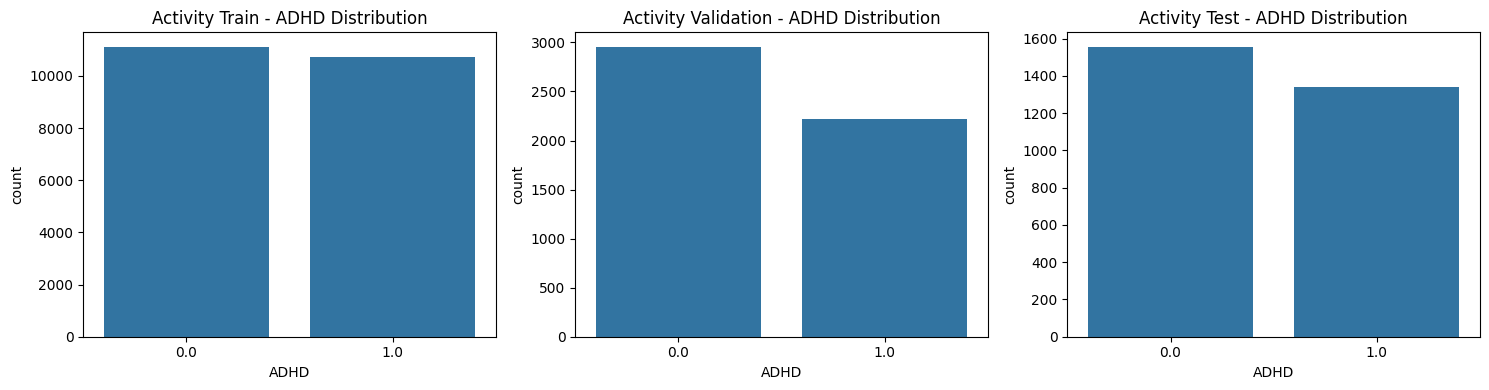

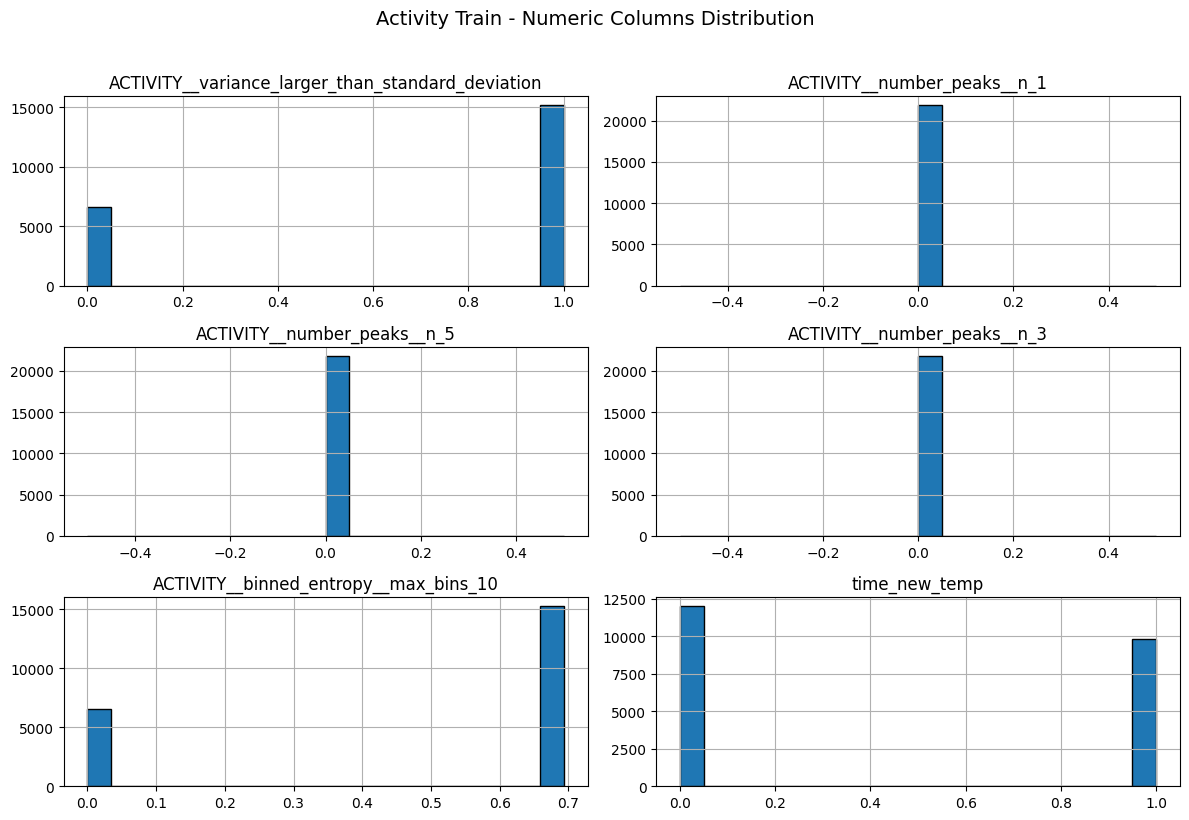

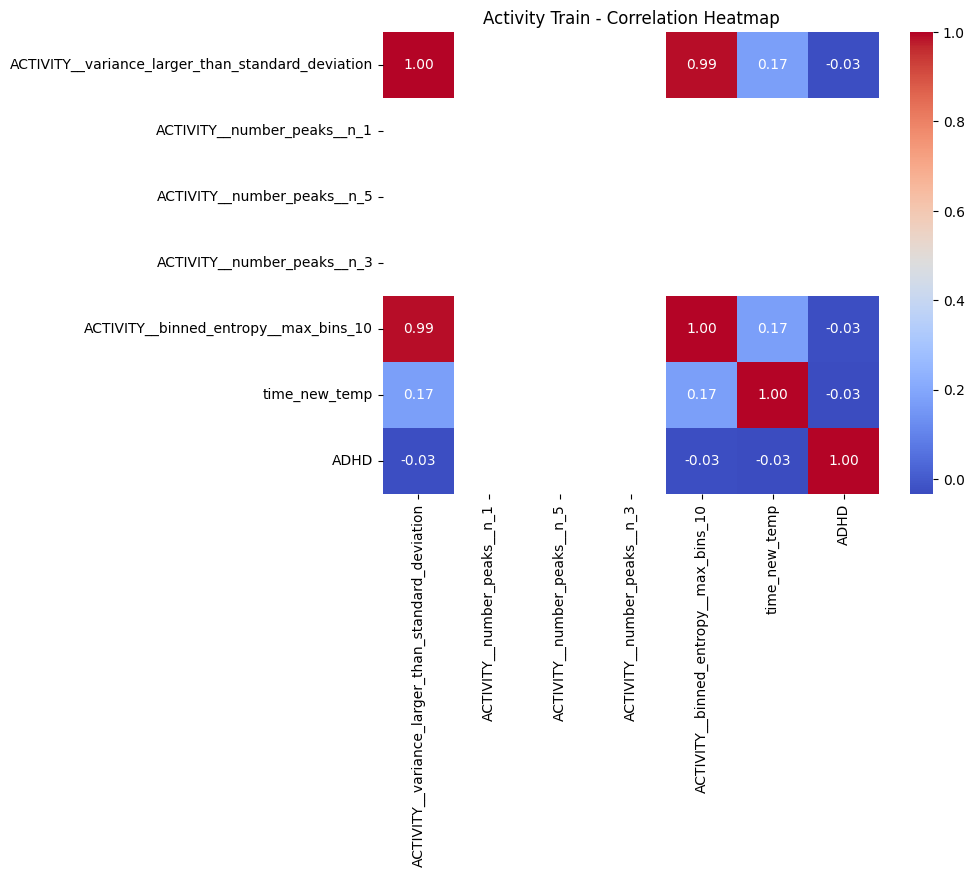


--- BPM DATA EDA ---
Train Shape: (21503, 10)
Validation Shape: (5512, 10)
Test Shape: (2895, 10)

Missing Values (Train):
 SDNN             0
RMSSD            0
NN50             0
pNN50            0
LF               0
HF               0
time_new_temp    0
LF/HF            0
Patient ID       0
ADHD             0
dtype: int64

Missing Values (Validation):
 SDNN             0
RMSSD            0
NN50             0
pNN50            0
LF               0
HF               0
time_new_temp    0
LF/HF            0
Patient ID       0
ADHD             0
dtype: int64

Missing Values (Test):
 SDNN             0
RMSSD            0
NN50             0
pNN50            0
LF               0
HF               0
time_new_temp    0
LF/HF            0
Patient ID       0
ADHD             0
dtype: int64


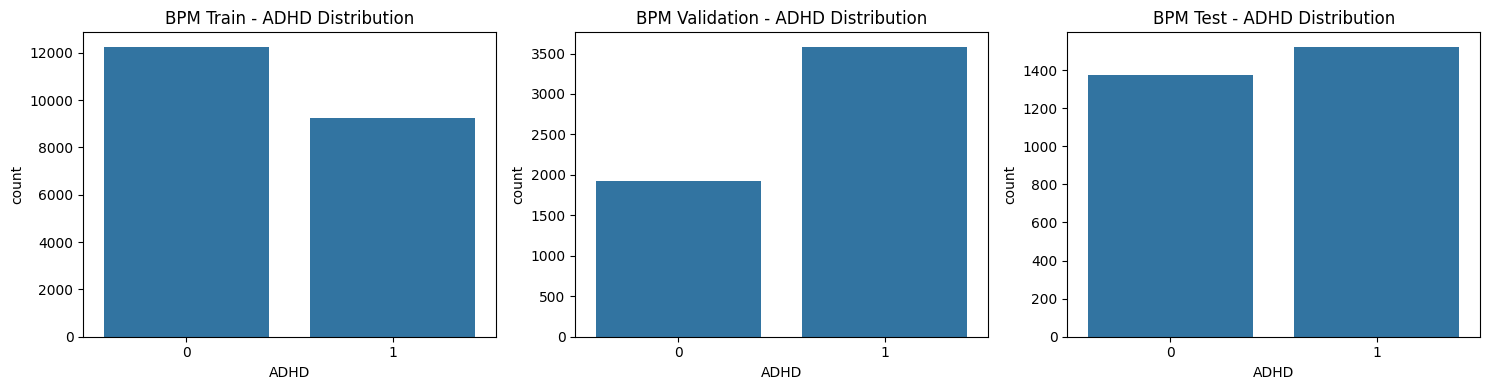

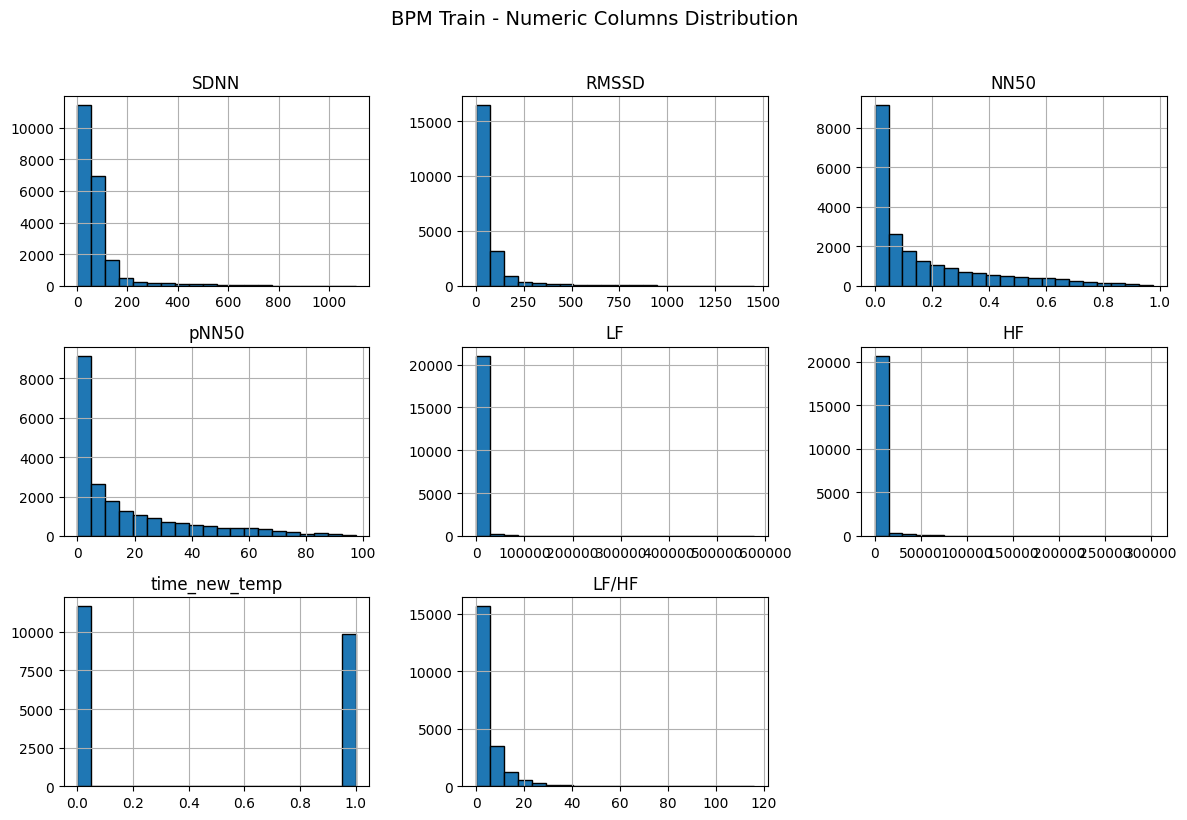

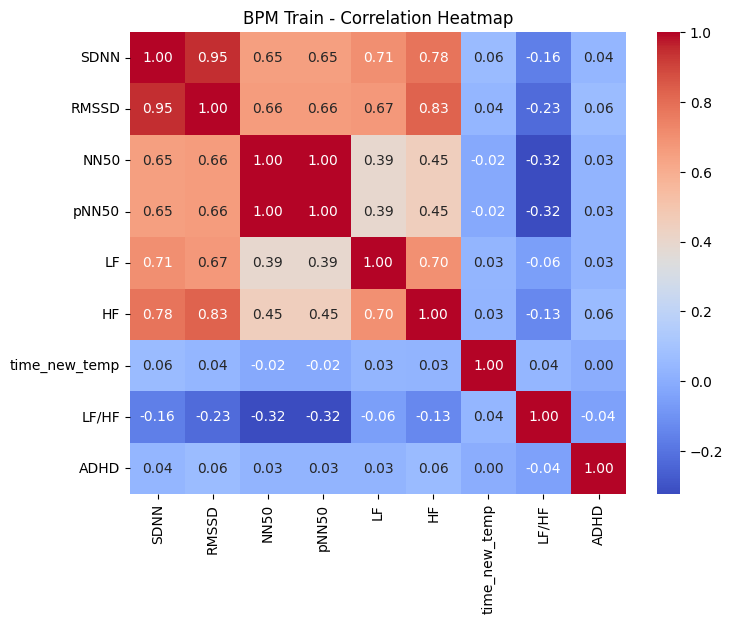

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

# -------------------------------
# 1. EDA for the Activity Dataset
# -------------------------------

def eda_activity_data(train_df, val_df, test_df, dataset_name="Activity"):
    print(f"\n--- {dataset_name} DATA EDA ---")
    
    # 1. Basic info about shapes
    print(f"Train Shape: {train_df.shape}")
    print(f"Validation Shape: {val_df.shape}")
    print(f"Test Shape: {test_df.shape}")
    
    # 2. Check for missing values
    print("\nMissing Values (Train):\n", train_df.isnull().sum())
    print("\nMissing Values (Validation):\n", val_df.isnull().sum())
    print("\nMissing Values (Test):\n", test_df.isnull().sum())
    
    # 3. Class distribution (ADHD vs. Non-ADHD) in each split
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    sns.countplot(data=train_df, x='ADHD', ax=axes[0])
    axes[0].set_title(f"{dataset_name} Train - ADHD Distribution")
    sns.countplot(data=val_df, x='ADHD', ax=axes[1])
    axes[1].set_title(f"{dataset_name} Validation - ADHD Distribution")
    sns.countplot(data=test_df, x='ADHD', ax=axes[2])
    axes[2].set_title(f"{dataset_name} Test - ADHD Distribution")
    plt.tight_layout()
    plt.show()
    
    # 4. Numeric feature distributions
    # Identify numeric columns (excluding 'Patient ID' and any non-numeric)
    numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
    # Remove ADHD if we want to focus on the features
    if 'ADHD' in numeric_cols:
        numeric_cols.remove('ADHD')
    if 'time_new_temp' in numeric_cols:
        # Keeping time_new_temp if needed, or remove it if it is not a direct feature
        pass

    # A quick histogram for each numeric column in train
    train_df[numeric_cols].hist(figsize=(12, 8), bins=20, edgecolor='black')
    plt.suptitle(f"{dataset_name} Train - Numeric Columns Distribution", y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

    # 5. Correlation matrix (Train set)
    corr = train_df[numeric_cols + ["ADHD"]].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f"{dataset_name} Train - Correlation Heatmap")
    plt.show()
    
    # 6. Show Duration / Time Range if TIMESTAMP column exists
    if 'TIMESTAMP' in train_df.columns:
        print(f"\n{dataset_name} Train - Timestamp Range:")
        print(f"  Min: {train_df['TIMESTAMP'].min()}")
        print(f"  Max: {train_df['TIMESTAMP'].max()}")
    if 'TIMESTAMP' in val_df.columns:
        print(f"{dataset_name} Validation - Timestamp Range:")
        print(f"  Min: {val_df['TIMESTAMP'].min()}")
        print(f"  Max: {val_df['TIMESTAMP'].max()}")
    if 'TIMESTAMP' in test_df.columns:
        print(f"{dataset_name} Test - Timestamp Range:")
        print(f"  Min: {test_df['TIMESTAMP'].min()}")
        print(f"  Max: {test_df['TIMESTAMP'].max()}")


# Perform EDA on the Activity data
eda_activity_data(activity_train, activity_val, activity_test, dataset_name="Activity")

# ---------------------------
# 2. EDA for the BPM Dataset
# ---------------------------

eda_activity_data(bpm_train, bpm_val, bpm_test, dataset_name="BPM")  # Reusing the same functio

In [36]:
activity_train.head()

,ACTIVITY__variance_larger_than_standard_deviation,ACTIVITY__number_peaks__n_1,ACTIVITY__number_peaks__n_5,ACTIVITY__number_peaks__n_3,ACTIVITY__binned_entropy__max_bins_10,time_new_temp,Patient ID,ADHD
0,1.0,0.0,0.0,0.0,0.693147,1,101,0.0
423,1.0,0.0,0.0,0.0,0.693147,1,101,0.0
424,0.0,0.0,0.0,0.0,-0.000000,1,101,0.0
425,0.0,0.0,0.0,0.0,-0.000000,1,101,0.0
426,0.0,0.0,0.0,0.0,-0.000000,1,101,0.0


In [37]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Prepare BPM features
bpm_features = ['SDNN', 'RMSSD', 'NN50', 'pNN50', 'LF', 'HF', 'time_new_temp',"LF/HF"]

# Prepare data for training
X_train = bpm_train[bpm_features]
y_train = bpm_train['ADHD']
X_val = bpm_val[bpm_features]
y_val = bpm_val['ADHD']
X_test = bpm_test[bpm_features]
y_test = bpm_test['ADHD']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Define models and their parameter grids
models = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        }
    },
    'SVC': {
        'model': SVC(random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['rbf', 'linear']
        }
    },
    'BernoulliNB': {
        'model': BernoulliNB(),
        'params': {
            'alpha': [0.1, 0.5, 1.0],
            'fit_prior': [True, False]
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear']
        }
    }
}

# Perform grid search for each model
best_models = {}
best_score = 0
best_model_name = None

for name, model_info in models.items():
    print(f"\nTraining {name}...")
    grid_search = GridSearchCV(
        model_info['model'],
        model_info['params'],
        cv=5,
        n_jobs=-1,
        scoring='accuracy'
    )
    grid_search.fit(X_train_scaled, y_train)
    
    best_models[name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'best_model': grid_search.best_estimator_
    }
    
    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_model_name = name

# Use the best model for final predictions
best_model = best_models[best_model_name]['best_model']
y_val_pred = best_model.predict(X_val_scaled)
y_test_pred = best_model.predict(X_test_scaled)

print("\nBest Model:", best_model_name)
print("Best Parameters:", best_models[best_model_name]['best_params'])
print("\nValidation Set Results:")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nTest Set Results:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))
print("\n===== Best Parameters and Scores for Each Model =====")
for name, result in best_models.items():
    print(f"\nModel: {name}")
    print("Best Parameters:", result['best_params'])
    print("Best Cross-Validation Accuracy:", result['best_score'])

print("\n===== Overall Best Model =====")
print("Best Model:", best_model_name)
print("Best Parameters:", best_models[best_model_name]['best_params'])
print("Best Cross-Validation Accuracy:", best_models[best_model_name]['best_score'])

print("\n===== Evaluation on Validation Set =====")
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))

print("\n===== Evaluation on Test Set =====")
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))



Training RandomForest...

Training GradientBoosting...

Training SVC...

Training BernoulliNB...

Training LogisticRegression...

Best Model: SVC
Best Parameters: {'C': 0.1, 'kernel': 'linear'}

Validation Set Results:
Accuracy: 0.340166908563135

Test Set Results:
Accuracy: 0.490846286701209

Classification Report:
              precision    recall  f1-score   support

           0       0.48      1.00      0.65      1373
           1       1.00      0.03      0.06      1522

    accuracy                           0.49      2895
   macro avg       0.74      0.52      0.36      2895
weighted avg       0.75      0.49      0.34      2895


===== Best Parameters and Scores for Each Model =====

Model: RandomForest
Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Best Cross-Validation Accuracy: 0.5014656732074207

Model: GradientBoosting
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Best Cross-Validation Accuracy: 0.5336949762

In [38]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from sklearn.model_selection import KFold
import random

def patient_based_cv_split_with_fixed_test(train_val_data, test_data, n_splits=3, random_state=42):
    """
    Create cross-validation splits based on patient IDs with a fixed test set
    """
    # Get unique patient IDs from train/val data (before _bin_number)
    train_val_patients = train_val_data['Patient ID'].apply(lambda x: x.split('_')[0]).unique()
    test_patients = test_data['Patient ID'].apply(lambda x: x.split('_')[0]).unique()
    
    # Verify no overlap between train/val and test patients
    assert len(set(train_val_patients) & set(test_patients)) == 0, "Overlap found between train/val and test patients!"
    
    # Create KFold splits for train/val
    np.random.seed(random_state)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    results = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(train_val_patients)):
        # Get patient IDs for this fold
        train_patients = train_val_patients[train_idx]
        val_patients = train_val_patients[val_idx]
        
        # Verify no overlap between train and validation patients
        assert len(set(train_patients) & set(val_patients)) == 0, f"Overlap found between train and val patients in fold {fold}!"
        
        # Create masks
        train_mask = train_val_data['Patient ID'].apply(lambda x: x.split('_')[0]).isin(train_patients)
        val_mask = train_val_data['Patient ID'].apply(lambda x: x.split('_')[0]).isin(val_patients)
        
        # Split data
        X_train = train_val_data[train_mask][bpm_features]
        y_train = train_val_data[train_mask]['ADHD']
        X_val = train_val_data[val_mask][bpm_features]
        y_val = train_val_data[val_mask]['ADHD']
        X_test = test_data[bpm_features]
        y_test = test_data['ADHD']
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)
        
        # Train and evaluate model
        svm = SVC(C=0.1, kernel='linear', random_state=42)
        svm.fit(X_train_scaled, y_train)
        
        # Get predictions
        train_pred = svm.predict(X_train_scaled)
        val_pred = svm.predict(X_val_scaled)
        test_pred = svm.predict(X_test_scaled)
        
        # Calculate metrics
        train_acc = accuracy_score(y_train, train_pred)
        val_acc = accuracy_score(y_val, val_pred)
        test_acc = accuracy_score(y_test, test_pred)
        
        results.append({
            'fold': fold + 1,
            'train_accuracy': train_acc,
            'val_accuracy': val_acc,
            'test_accuracy': test_acc,
            'test_report': classification_report(y_test, test_pred)
        })
        
    return results

# Run cross-validation with fixed test set
cv_results = patient_based_cv_split_with_fixed_test(
    train_val_data=pd.concat([bpm_train, bpm_val]),
    test_data=bpm_test,
    n_splits=7
)

# Print results
print("Cross-validation Results:")
for result in cv_results:
    print(f"\nFold {result['fold']}:")
    print(f"Train Accuracy: {result['train_accuracy']:.4f}")
    print(f"Validation Accuracy: {result['val_accuracy']:.4f}")
    print(f"Test Accuracy: {result['test_accuracy']:.4f}")
    print("\nTest Classification Report:")
    print(result['test_report'])

# Calculate average metrics
avg_train_acc = np.mean([r['train_accuracy'] for r in cv_results])
avg_val_acc = np.mean([r['val_accuracy'] for r in cv_results])
avg_test_acc = np.mean([r['test_accuracy'] for r in cv_results])
std_test_acc = np.std([r['test_accuracy'] for r in cv_results])

print("\nOverall Results:")
print(f"Average Train Accuracy: {avg_train_acc:.4f}")
print(f"Average Validation Accuracy: {avg_val_acc:.4f}")
print(f"Average Test Accuracy: {avg_test_acc:.4f} (+/- {std_test_acc:.4f})")

/home/aditya22040/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aditya22040/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aditya22040/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aditya22040/.local/

Cross-validation Results:

Fold 1:
Train Accuracy: 0.5374
Validation Accuracy: 0.4602
Test Accuracy: 0.4743

Test Classification Report:
              precision    recall  f1-score   support

           0       0.47      1.00      0.64      1373
           1       0.00      0.00      0.00      1522

    accuracy                           0.47      2895
   macro avg       0.24      0.50      0.32      2895
weighted avg       0.22      0.47      0.31      2895


Fold 2:
Train Accuracy: 0.5178
Validation Accuracy: 0.6146
Test Accuracy: 0.6138

Test Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.86      0.68      1373
           1       0.76      0.39      0.51      1522

    accuracy                           0.61      2895
   macro avg       0.66      0.63      0.60      2895
weighted avg       0.66      0.61      0.59      2895


Fold 3:
Train Accuracy: 0.5532
Validation Accuracy: 0.3908
Test Accuracy: 0.5233

Test Classifica

In [45]:
# Example usage:
# For Activity data
activity_train, activity_val, activity_test = patient_based_split_spl(activity_data,random_state=42)

# For BPM data
bpm_train, bpm_val, bpm_test = patient_based_split_spl(bpm_data,random_state=69)

Train set: 21504 samples (36 patients)
Validation set: 5512 samples (9 patients)
Test set: 2895 samples (5 patients)
Test Patient IDs: ['19', '27', '33', '48', '75']
Train set: 21480 samples (36 patients)
Validation set: 5535 samples (9 patients)
Test set: 2895 samples (5 patients)
Test Patient IDs: ['19', '27', '33', '48', '75']



Training RandomForest...

Training GradientBoosting...

Training SVC...

Training BernoulliNB...

Training LogisticRegression...

Training SGDClassifier...


/home/aditya22040/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/aditya22040/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/aditya22040/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/aditya22040/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warning


Training GaussianNB...


--- Test Set Performance for All Models  Activity ---

Model: RandomForest
  Accuracy:  0.55
  Precision: 0.53
  Recall:    0.16
  F1-Score:  0.24
  MCC:       0.06
  Classification Report:
              precision    recall  f1-score   support

         0.0       0.55      0.88      0.68      1556
         1.0       0.53      0.16      0.24      1339

    accuracy                           0.55      2895
   macro avg       0.54      0.52      0.46      2895
weighted avg       0.54      0.55      0.48      2895



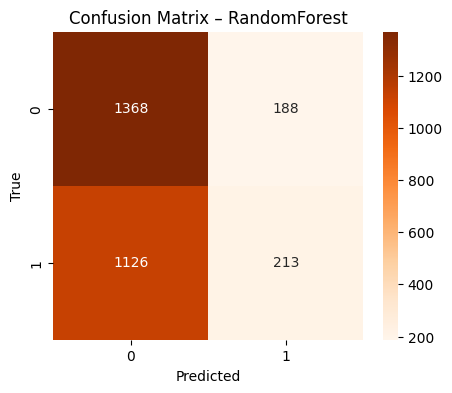

--------------------------------------------------
Model: GradientBoosting
  Accuracy:  0.55
  Precision: 0.53
  Recall:    0.16
  F1-Score:  0.24
  MCC:       0.06
  Classification Report:
              precision    recall  f1-score   support

         0.0       0.55      0.88      0.68      1556
         1.0       0.53      0.16      0.24      1339

    accuracy                           0.55      2895
   macro avg       0.54      0.52      0.46      2895
weighted avg       0.54      0.55      0.48      2895



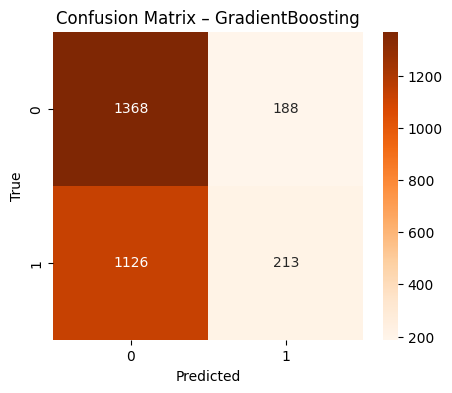

--------------------------------------------------
Model: SVC
  Accuracy:  0.60
  Precision: 0.61
  Recall:    0.38
  F1-Score:  0.47
  MCC:       0.19
  Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.79      0.68      1556
         1.0       0.61      0.38      0.47      1339

    accuracy                           0.60      2895
   macro avg       0.61      0.59      0.58      2895
weighted avg       0.61      0.60      0.58      2895



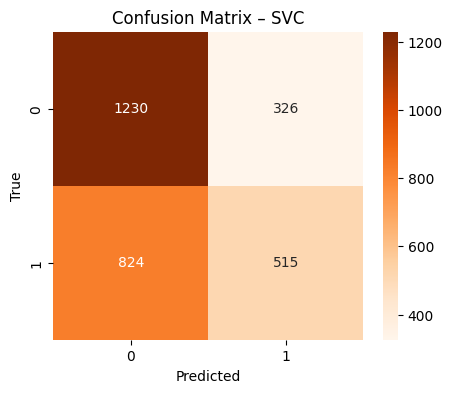

--------------------------------------------------
Model: BernoulliNB
  Accuracy:  0.60
  Precision: 0.61
  Recall:    0.39
  F1-Score:  0.47
  MCC:       0.19
  Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.79      0.68      1556
         1.0       0.61      0.39      0.47      1339

    accuracy                           0.60      2895
   macro avg       0.61      0.59      0.58      2895
weighted avg       0.61      0.60      0.59      2895



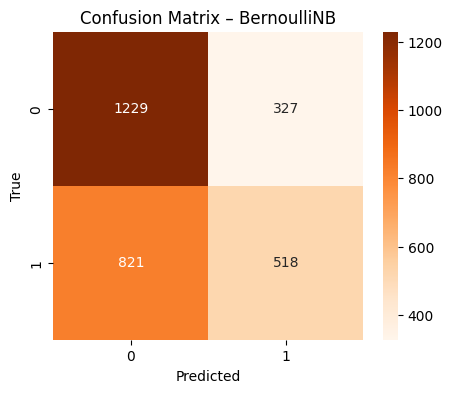

--------------------------------------------------
Model: LogisticRegression
  Accuracy:  0.57
  Precision: 0.52
  Recall:    0.74
  F1-Score:  0.61
  MCC:       0.17
  Classification Report:
              precision    recall  f1-score   support

         0.0       0.65      0.42      0.51      1556
         1.0       0.52      0.74      0.61      1339

    accuracy                           0.57      2895
   macro avg       0.59      0.58      0.56      2895
weighted avg       0.59      0.57      0.56      2895



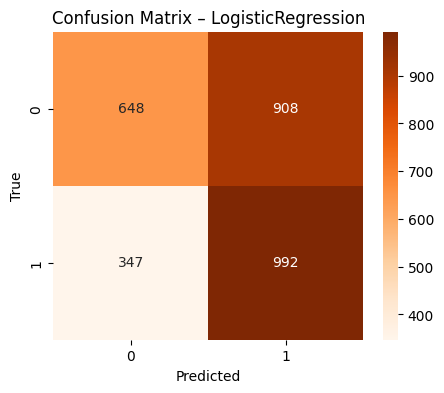

--------------------------------------------------
Model: SGDClassifier
  Accuracy:  0.60
  Precision: 0.61
  Recall:    0.38
  F1-Score:  0.47
  MCC:       0.19
  Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.79      0.68      1556
         1.0       0.61      0.38      0.47      1339

    accuracy                           0.60      2895
   macro avg       0.61      0.59      0.58      2895
weighted avg       0.61      0.60      0.58      2895



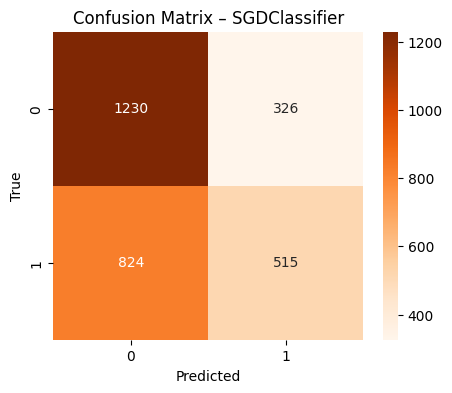

--------------------------------------------------
Model: GaussianNB
  Accuracy:  0.60
  Precision: 0.61
  Recall:    0.39
  F1-Score:  0.47
  MCC:       0.19
  Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.79      0.68      1556
         1.0       0.61      0.39      0.47      1339

    accuracy                           0.60      2895
   macro avg       0.61      0.59      0.58      2895
weighted avg       0.61      0.60      0.59      2895



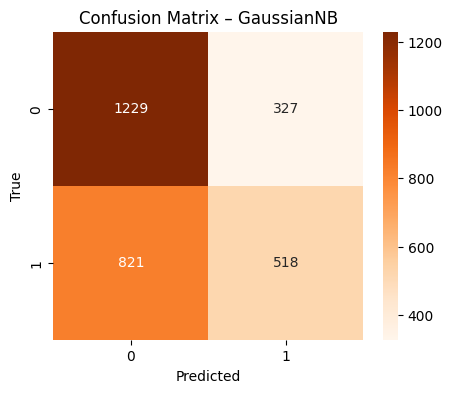

--------------------------------------------------

Best Model: SGDClassifier
Best Parameters: {'alpha': 0.0001, 'loss': 'log', 'penalty': 'l2'}

Validation Set Results:
Accuracy: 0.5455370101596516

Test Set Results:
Accuracy: 0.6027633851468048

Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.79      0.68      1556
         1.0       0.61      0.38      0.47      1339

    accuracy                           0.60      2895
   macro avg       0.61      0.59      0.58      2895
weighted avg       0.61      0.60      0.58      2895



In [64]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for training
X_train = activity_train.drop(['Patient ID', 'ADHD'], axis=1)
y_train = activity_train['ADHD']
X_val = activity_val.drop(['Patient ID', 'ADHD'], axis=1)
y_val = activity_val['ADHD']
X_test = activity_test.drop(['Patient ID', 'ADHD'], axis=1)
y_test = activity_test['ADHD']

# X_train.head()
from sklearn.naive_bayes import BernoulliNB,GaussianNB
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
from imblearn.over_sampling import SMOTE
# Apply SMOTE to the training data
smote = SMOTE(random_state=0)
X_train_scaled, y_train = smote.fit_resample(X_train_scaled, y_train)

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Define models and their parameter grids
models = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        }
    },
    'SVC': {
        'model': SVC(random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['rbf', 'linear']
        }
    },
    'BernoulliNB': {
        'model': BernoulliNB(),
        'params': {
            'alpha': [0.1, 0.5, 1.0],
            'fit_prior': [True, False]
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear']
        }
    },
    'SGDClassifier': {
        'model': SGDClassifier(random_state=42, max_iter=1000),
        'params': {
            'loss': ['hinge', 'log'],
            'alpha': [0.0001, 0.001],
            'penalty': ['l2', 'l1']
        }
    },
    "GaussianNB": {
        'model': GaussianNB(),
        'params': {
            'var_smoothing': [1e-9, 1e-8, 1e-7]
        }
    },
    
}

# Perform grid search for each model
best_models = {}
best_score = 0
best_model_name = None

for name, model_info in models.items():
    print(f"\nTraining {name}...")
    grid_search = GridSearchCV(
        model_info['model'],
        model_info['params'],
        cv=5,
        n_jobs=-1,
        scoring='accuracy'
    )
    grid_search.fit(X_train_scaled, y_train)
    
    best_models[name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'best_model': grid_search.best_estimator_
    }
    
    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_model_name = name

from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef

print("\n\n--- Test Set Performance for All Models  Activity ---\n")

for name, model_info in best_models.items():
    model = model_info['best_model']
    y_test_pred = model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    mcc = matthews_corrcoef(y_test, y_test_pred)
    
    print(f"Model: {name}")
    print(f"  Accuracy:  {accuracy:.2f}")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall:    {recall:.2f}")
    print(f"  F1-Score:  {f1:.2f}")
    print(f"  MCC:       {mcc:.2f}")
    print("  Classification Report:")
    print(classification_report(y_test, y_test_pred))
    cm = confusion_matrix(y_test, y_test_pred)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges")
    plt.title(f"Confusion Matrix – {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    print("-" * 50)


# Use the best model for final predictions
best_model = best_models[best_model_name]['best_model']
y_val_pred = best_model.predict(X_val_scaled)
y_test_pred = best_model.predict(X_test_scaled)

print("\nBest Model:", best_model_name)
print("Best Parameters:", best_models[best_model_name]['best_params'])
print("\nValidation Set Results:")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nTest Set Results:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))


In [47]:
activity_val.shape

(5512, 8)

In [48]:
print("\n===== Best Parameters and Scores for Each Model =====")
for name, result in best_models.items():
    print(f"\nModel: {name}")
    print("Best Parameters:", result['best_params'])
    print("Best Cross-Validation Accuracy:", result['best_score'])

print("\n===== Overall Best Model =====")
print("Best Model:", best_model_name)
print("Best Parameters:", best_models[best_model_name]['best_params'])
print("Best Cross-Validation Accuracy:", best_models[best_model_name]['best_score'])

print("\n===== Evaluation on Validation Set =====")
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))

print("\n===== Evaluation on Test Set =====")
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))



===== Best Parameters and Scores for Each Model =====

Model: RandomForest
Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-Validation Accuracy: 0.49982090451449823

Model: GradientBoosting
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Best Cross-Validation Accuracy: 0.49982090451449823

Model: SVC
Best Parameters: {'C': 0.1, 'kernel': 'linear'}
Best Cross-Validation Accuracy: 0.5051901459699117

Model: BernoulliNB
Best Parameters: {'alpha': 0.1, 'fit_prior': True}
Best Cross-Validation Accuracy: 0.5024602777786404

Model: LogisticRegression
Best Parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Cross-Validation Accuracy: 0.5052356418752801

Model: SGDClassifier
Best Parameters: {'alpha': 0.0001, 'loss': 'log', 'penalty': 'l2'}
Best Cross-Validation Accuracy: 0.5192038475354055

Model: GaussianNB
Best Parameters: {'var_smoothing': 1e-09}
Best Cross-Validation Accuracy: 0.5141981696050085

=====


Training RandomForest...

Training GradientBoosting...

Training SVC...

Training BernoulliNB...

Training LogisticRegression...

Training GaussianNB...

Training SGDClassifier...


/home/aditya22040/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/aditya22040/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/aditya22040/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/aditya22040/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warning



--- Test Set Performance for All Models  Hrv  ---

Model: RandomForest
  Accuracy:  0.53
  Precision: 0.56
  Recall:    0.44
  F1-Score:  0.49
  MCC:       0.06
  Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.63      0.56      1373
           1       0.56      0.44      0.49      1522

    accuracy                           0.53      2895
   macro avg       0.53      0.53      0.52      2895
weighted avg       0.53      0.53      0.52      2895



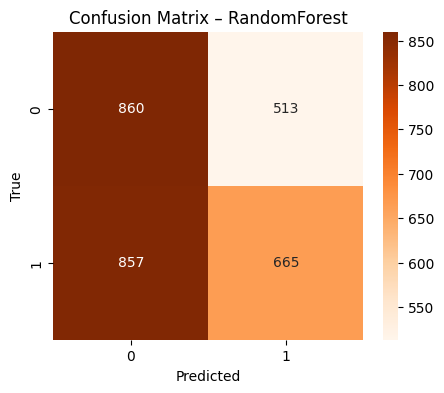

--------------------------------------------------
Model: GradientBoosting
  Accuracy:  0.52
  Precision: 0.55
  Recall:    0.42
  F1-Score:  0.47
  MCC:       0.04
  Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.63      0.55      1373
           1       0.55      0.42      0.47      1522

    accuracy                           0.52      2895
   macro avg       0.52      0.52      0.51      2895
weighted avg       0.52      0.52      0.51      2895



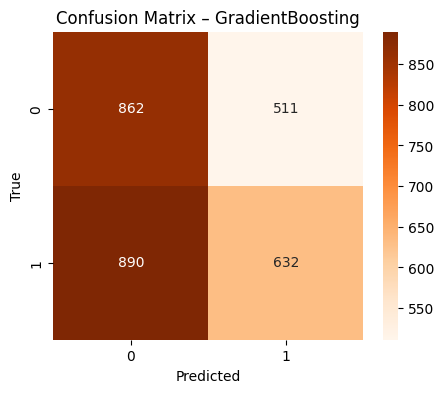

--------------------------------------------------
Model: SVC
  Accuracy:  0.48
  Precision: 0.51
  Recall:    0.43
  F1-Score:  0.46
  MCC:       -0.04
  Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.53      0.49      1373
           1       0.51      0.43      0.46      1522

    accuracy                           0.48      2895
   macro avg       0.48      0.48      0.48      2895
weighted avg       0.48      0.48      0.48      2895



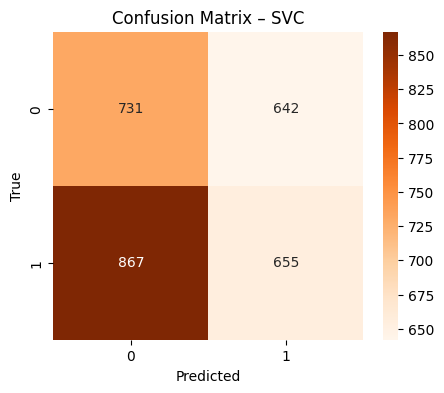

--------------------------------------------------
Model: BernoulliNB
  Accuracy:  0.51
  Precision: 0.54
  Recall:    0.52
  F1-Score:  0.53
  MCC:       0.03
  Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.51      0.50      1373
           1       0.54      0.52      0.53      1522

    accuracy                           0.51      2895
   macro avg       0.51      0.51      0.51      2895
weighted avg       0.51      0.51      0.51      2895



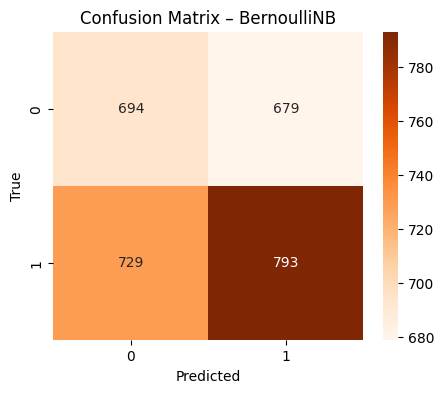

--------------------------------------------------
Model: LogisticRegression
  Accuracy:  0.48
  Precision: 0.51
  Recall:    0.38
  F1-Score:  0.44
  MCC:       -0.03
  Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.58      0.52      1373
           1       0.51      0.38      0.44      1522

    accuracy                           0.48      2895
   macro avg       0.48      0.48      0.48      2895
weighted avg       0.49      0.48      0.47      2895



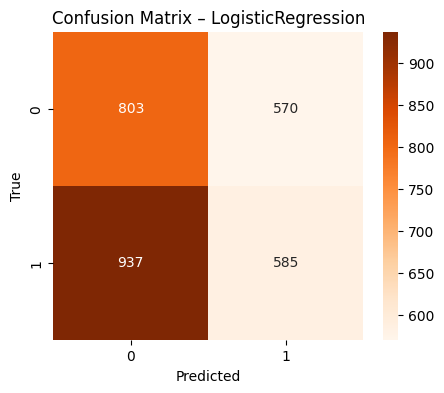

--------------------------------------------------
Model: GaussianNB
  Accuracy:  0.59
  Precision: 0.95
  Recall:    0.24
  F1-Score:  0.38
  MCC:       0.33
  Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.99      0.70      1373
           1       0.95      0.24      0.38      1522

    accuracy                           0.59      2895
   macro avg       0.74      0.61      0.54      2895
weighted avg       0.75      0.59      0.53      2895



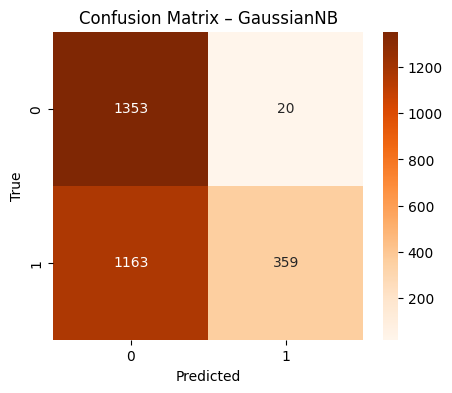

--------------------------------------------------
Model: SGDClassifier
  Accuracy:  0.46
  Precision: 0.49
  Recall:    0.57
  F1-Score:  0.52
  MCC:       -0.09
  Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.34      0.38      1373
           1       0.49      0.57      0.52      1522

    accuracy                           0.46      2895
   macro avg       0.45      0.45      0.45      2895
weighted avg       0.45      0.46      0.45      2895



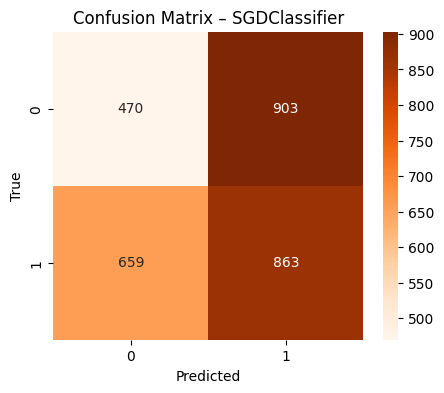

--------------------------------------------------


In [65]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.naive_bayes import GaussianNB  
# Prepare data for training
X_train = bpm_train.drop(['Patient ID', 'ADHD'], axis=1)
y_train = bpm_train['ADHD']
X_val = bpm_val.drop(['Patient ID', 'ADHD'], axis=1)
y_val = bpm_val['ADHD']
X_test = bpm_test.drop(['Patient ID', 'ADHD'], axis=1)
y_test = bpm_test['ADHD']

# X_train.head()
from imblearn.over_sampling import SMOTE
# from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
X_train_scaled, y_train = smote.fit_resample(X_train_scaled, y_train)
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Define models and their parameter grids
models = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        }
    },
    'SVC': {
        'model': SVC(random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['rbf', 'linear']
        }
    },
    'BernoulliNB': {
        'model': BernoulliNB(),
        'params': {
            'alpha': [0.1, 0.5, 1.0],
            'fit_prior': [True, False]
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear']
        }
    },
    'GaussianNB': {
        'model': GaussianNB(),
        'params': {
            'var_smoothing': [1e-9, 1e-8, 1e-7]
        }
    },
    'SGDClassifier': {
        'model': SGDClassifier(random_state=42, max_iter=1000),
        'params': {
            'loss': ['hinge', 'log'],
            'alpha': [0.0001, 0.001],
            'penalty': ['l2', 'l1']
        }
    },
}
from sklearn.naive_bayes import GaussianNB

# Perform grid search for each model
best_models = {}
best_score = 0
best_model_name = None

for name, model_info in models.items():
    print(f"\nTraining {name}...")
    grid_search = GridSearchCV(
        model_info['model'],
        model_info['params'],
        cv=5,
        n_jobs=-1,
        scoring='accuracy'
    )
    grid_search.fit(X_train_scaled, y_train)
    
    best_models[name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'best_model': grid_search.best_estimator_
    }
    
    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_model_name = name

from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef

print("\n\n--- Test Set Performance for All Models  Hrv  ---\n")

for name, model_info in best_models.items():
    model = model_info['best_model']
    y_test_pred = model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    mcc = matthews_corrcoef(y_test, y_test_pred)
    
    print(f"Model: {name}")
    print(f"  Accuracy:  {accuracy:.2f}")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall:    {recall:.2f}")
    print(f"  F1-Score:  {f1:.2f}")
    print(f"  MCC:       {mcc:.2f}")
    print("  Classification Report:")
    print(classification_report(y_test, y_test_pred))
    cm = confusion_matrix(y_test, y_test_pred)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges")
    plt.title(f"Confusion Matrix – {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    print("-" * 50)
# # Use the best model for final predictions
# best_model = best_models[best_model_name]['best_model']
# best_model = GaussianNB()
# best_model.fit(X_train_scaled, y_train)
# y_val_pred = best_model.predict(X_val_scaled)
# y_test_pred = best_model.predict(X_test_scaled)

# print("\nBest Model:", best_model_name)
# # print("Best Parameters:", best_models[best_model_name]['best_params'])
# print("\nValidation Set Results:")
# print("Accuracy:", accuracy_score(y_val, y_val_pred))
# print("\nTest Set Results:")
# print("Accuracy:", accuracy_score(y_test, y_test_pred))
# print("\nClassification Report:")
# print(classification_report(y_test, y_test_pred))


In [50]:
print("\n===== Best Parameters and Scores for Each Model ON HRV=====")
for name, result in best_models.items():
    print(f"\nModel: {name}")
    print("Best Parameters:", result['best_params'])
    # print("Best Cross-Validation Accuracy:", result['best_score'])

# print("\n===== Overall Best Model =====")
# print("Best Model:", best_model_name)
# print("Best Parameters:", best_models[best_model_name]['best_params'])
# print("Best Cross-Validation Accuracy:", best_models[best_model_name]['best_score'])

# print("\n===== Evaluation on Validation Set =====")
# print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))

# print("\n===== Evaluation on Test Set =====")
# print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
# print("\nClassification Report (Test Set):")
# print(classification_report(y_test, y_test_pred))


===== Best Parameters and Scores for Each Model ON HRV=====

Model: RandomForest
Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}

Model: GradientBoosting
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}

Model: SVC
Best Parameters: {'C': 0.1, 'kernel': 'rbf'}

Model: BernoulliNB
Best Parameters: {'alpha': 0.1, 'fit_prior': True}

Model: LogisticRegression
Best Parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

Model: GaussianNB
Best Parameters: {'var_smoothing': 1e-09}

Model: SGDClassifier
Best Parameters: {'alpha': 0.0001, 'loss': 'log', 'penalty': 'l1'}


In [53]:
bpm_tmp_data_cpy = bpm_tmp_data.copy()
bpm_tmp_data_cpy["Patient ID"] = bpm_tmp_data_cpy["Patient ID"].apply(lambda x: x.split("_")[0])
bpm_tmp_data_cpy["Patient ID"] = bpm_tmp_data_cpy["Patient ID"].astype(str)
bpm_tmp_data_copy.sort_values(by=["Patient ID","TIMESTAMP"], inplace=True)
activity_features_tmp_cpy = activity_features_tmp.copy()
activity_features_tmp_cpy.sort_values(by=["Patient ID","TIMESTAMP"], inplace=True)

multi_spl = pd.merge(bpm_tmp_data_cpy, activity_features_tmp_cpy, on=["Patient ID","TIMESTAMP"], how="inner")
multi_spl.drop(columns=["TIMESTAMP"], inplace=True)
multi_spl["ADHD"].value_counts()    

ADHD
1    12524
0    11494
Name: count, dtype: int64

In [59]:
bpm_tmp_data_cpy = bpm_tmp_data.copy()
bpm_tmp_data_cpy["Patient ID"] = bpm_tmp_data_cpy["Patient ID"].apply(lambda x: x.split("_")[0])
bpm_tmp_data_cpy["Patient ID"] = bpm_tmp_data_cpy["Patient ID"].astype(str)
bpm_tmp_data_copy.sort_values(by=["Patient ID","TIMESTAMP"], inplace=True)
activity_features_tmp_cpy = activity_features_tmp.copy()
activity_features_tmp_cpy.sort_values(by=["Patient ID","TIMESTAMP"], inplace=True)

multi_spl = pd.merge(bpm_tmp_data_cpy, activity_features_tmp_cpy, on=["Patient ID","TIMESTAMP"], how="inner")
multi_spl.dropna(inplace=True)
multi_spl.drop(columns=["TIMESTAMP"], inplace=True)
multi_spl["ADHD"].value_counts()    
multi_train, multi_val, multi_test = patient_based_split_spl(multi_spl)

multi_test["Patient ID"].unique()
multi_train.drop(columns=["HR"], inplace=True)
multi_val.drop(columns=["HR"], inplace=True)
multi_test.drop(columns=["HR"], inplace=True)

Train set: 17613 samples (29 patients)
Validation set: 4338 samples (8 patients)
Test set: 2066 samples (4 patients)
Test Patient IDs: ['19', '27', '48', '75']



Training RandomForest...

Training GradientBoosting...

Training SVC...

Training BernoulliNB...

Training LogisticRegression...

Training GaussianNB...

Training SGDClassifier...


/home/aditya22040/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/aditya22040/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/aditya22040/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/aditya22040/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warning



--- Test Set Performance for All Models  MULTIMODAL ---

Model: RandomForest
  Accuracy:  0.51
  Precision: 0.74
  Recall:    0.52
  F1-Score:  0.61
  MCC:       0.00
  Classification Report:
              precision    recall  f1-score   support

           0       0.26      0.49      0.34       544
           1       0.74      0.52      0.61      1522

    accuracy                           0.51      2066
   macro avg       0.50      0.50      0.48      2066
weighted avg       0.61      0.51      0.54      2066



/home/aditya22040/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


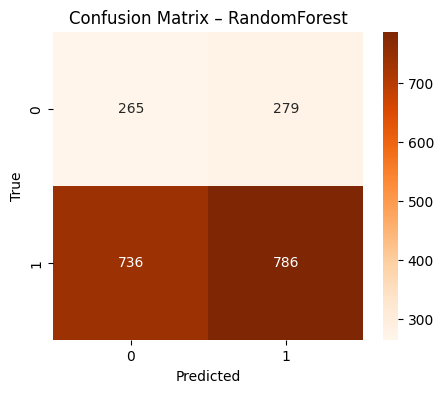

--------------------------------------------------
Model: GradientBoosting
  Accuracy:  0.53
  Precision: 0.73
  Recall:    0.58
  F1-Score:  0.65
  MCC:       -0.02
  Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.39      0.31       544
           1       0.73      0.58      0.65      1522

    accuracy                           0.53      2066
   macro avg       0.49      0.49      0.48      2066
weighted avg       0.60      0.53      0.56      2066



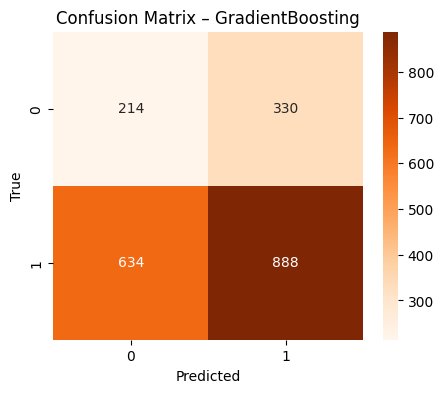

--------------------------------------------------
Model: SVC
  Accuracy:  0.60
  Precision: 0.79
  Recall:    0.62
  F1-Score:  0.69
  MCC:       0.13
  Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.53      0.41       544
           1       0.79      0.62      0.69      1522

    accuracy                           0.60      2066
   macro avg       0.56      0.57      0.55      2066
weighted avg       0.67      0.60      0.62      2066



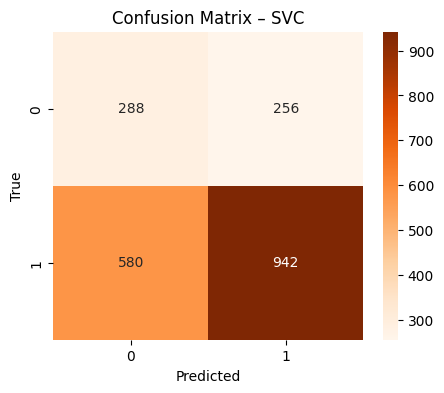

--------------------------------------------------
Model: BernoulliNB
  Accuracy:  0.74
  Precision: 0.95
  Recall:    0.69
  F1-Score:  0.79
  MCC:       0.51
  Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.89      0.64       544
           1       0.95      0.69      0.79      1522

    accuracy                           0.74      2066
   macro avg       0.72      0.79      0.72      2066
weighted avg       0.83      0.74      0.76      2066



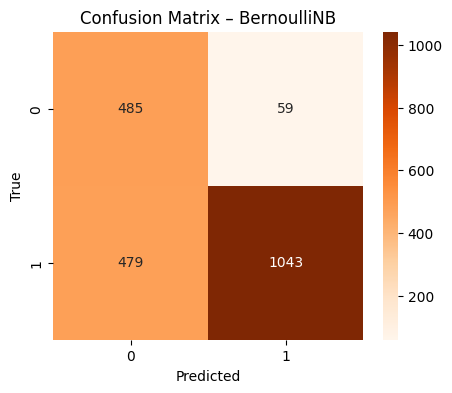

--------------------------------------------------
Model: LogisticRegression
  Accuracy:  0.59
  Precision: 0.85
  Recall:    0.53
  F1-Score:  0.66
  MCC:       0.24
  Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.74      0.49       544
           1       0.85      0.53      0.66      1522

    accuracy                           0.59      2066
   macro avg       0.61      0.64      0.57      2066
weighted avg       0.72      0.59      0.61      2066



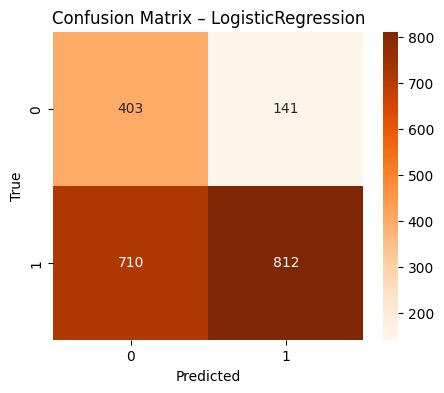

--------------------------------------------------
Model: GaussianNB
  Accuracy:  0.43
  Precision: 0.97
  Recall:    0.23
  F1-Score:  0.38
  MCC:       0.25
  Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.98      0.48       544
           1       0.97      0.23      0.38      1522

    accuracy                           0.43      2066
   macro avg       0.64      0.61      0.43      2066
weighted avg       0.80      0.43      0.40      2066



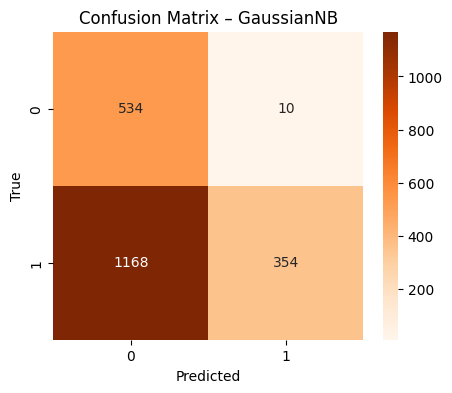

--------------------------------------------------
Model: SGDClassifier
  Accuracy:  0.42
  Precision: 0.62
  Recall:    0.54
  F1-Score:  0.58
  MCC:       -0.35
  Classification Report:
              precision    recall  f1-score   support

           0       0.06      0.08      0.07       544
           1       0.62      0.54      0.58      1522

    accuracy                           0.42      2066
   macro avg       0.34      0.31      0.32      2066
weighted avg       0.47      0.42      0.45      2066



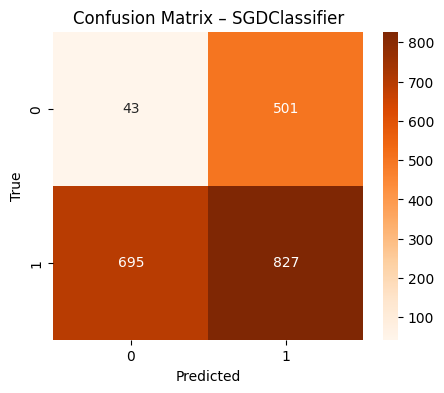

--------------------------------------------------


In [63]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Prepare data for training
X_train = multi_train.drop(['Patient ID', 'ADHD'], axis=1)
y_train = multi_train['ADHD']
X_val = multi_val.drop(['Patient ID', 'ADHD'], axis=1)
y_val = multi_val['ADHD']
X_test = multi_test.drop(['Patient ID', 'ADHD'], axis=1)
y_test = multi_test['ADHD']

from imblearn.over_sampling import SMOTE
# from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)



# X_train.head()

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
X_train_scaled, y_train = smote.fit_resample(X_train_scaled, y_train)
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Define models and their parameter grids
models = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        }
    },
    'SVC': {
        'model': SVC(random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['rbf', 'linear']
        }
    },
    'BernoulliNB': {
        'model': BernoulliNB(),
        'params': {
            'alpha': [0.1, 0.5, 1.0],
            'fit_prior': [True, False]
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear']
        }
    },
    'GaussianNB': {
        'model': GaussianNB(),
        'params': {
            'var_smoothing': [1e-9, 1e-8, 1e-7]
        }
    },
    'SGDClassifier': {
        'model': SGDClassifier(random_state=42, max_iter=1000),
        'params': {
            'loss': ['hinge', 'log'],
            'alpha': [0.0001, 0.001],
            'penalty': ['l2', 'l1']
        }
    },
}
from sklearn.naive_bayes import GaussianNB

# Perform grid search for each model
best_models = {}
best_score = 0
best_model_name = None

for name, model_info in models.items():
    print(f"\nTraining {name}...")
    grid_search = GridSearchCV(
        model_info['model'],
        model_info['params'],
        cv=5,
        n_jobs=-1,
        scoring='accuracy'
    )
    grid_search.fit(X_train_scaled, y_train)
    
    best_models[name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'best_model': grid_search.best_estimator_
    }
    
    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_model_name = name
    
    # print("\nBest Model:", best_model_name)
    # # print("Best Parameters:", best_models[best_model_name]['best_params'])
    # # print("\nValidation Set Results:")
    # # print("Accuracy:", accuracy_score(y_val, y_val_pred))
    # print("\nTest Set Results:")
    # print("Accuracy:", accuracy_score(y_test, y_test_pred))
    # print("\nClassification Report:")
    # print(classification_report(y_test, y_test_pred))
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef

print("\n\n--- Test Set Performance for All Models  MULTIMODAL ---\n")

for name, model_info in best_models.items():
    model = model_info['best_model']
    y_test_pred = model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    mcc = matthews_corrcoef(y_test, y_test_pred)
    
    print(f"Model: {name}")
    print(f"  Accuracy:  {accuracy:.2f}")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall:    {recall:.2f}")
    print(f"  F1-Score:  {f1:.2f}")
    print(f"  MCC:       {mcc:.2f}")
    print("  Classification Report:")
    print(classification_report(y_test, y_test_pred))
    cm = confusion_matrix(y_test, y_test_pred)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges")
    plt.title(f"Confusion Matrix – {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    print("-" * 50)
    
# # # Use the best model for final predictions
# # best_model = best_models[best_model_name]['best_model']
# best_model = BernoulliNB()
# best_model.fit(X_train_scaled, y_train)
# y_val_pred = best_model.predict(X_val_scaled)
# y_test_pred = best_model.predict(X_test_scaled)

# print("\nBest Model:", best_model_name)
# # print("Best Parameters:", best_models[best_model_name]['best_params'])
# print("\nValidation Set Results:")
# print("Accuracy:", accuracy_score(y_val, y_val_pred))
# print("\nTest Set Results:")
# print("Accuracy:", accuracy_score(y_test, y_test_pred))
# print("\nClassification Report:")
# print(classification_report(y_test, y_test_pred))


In [61]:
print("\n===== Best Parameters and Scores for Each Model ON multimodal=====")
for name, result in best_models.items():
    print(f"\nModel: {name}")
    print("Best Parameters:", result['best_params'])
    # print("Best Cross-Validation Accuracy:", result['best_score'])

# print("\n===== Overall Best Model =====")
# print("Best Model:", best_model_name)
# print("Best Parameters:", best_models[best_model_name]['best_params'])
# print("Best Cross-Validation Accuracy:", best_models[best_model_name]['best_score'])

# print("\n===== Evaluation on Validation Set =====")
# print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))

# print("\n===== Evaluation on Test Set =====")
# print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
# print("\nClassification Report (Test Set):")
# print(classification_report(y_test, y_test_pred))



===== Best Parameters and Scores for Each Model ON multimodal=====

Model: RandomForest
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}

Model: GradientBoosting
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}

Model: SVC
Best Parameters: {'C': 10, 'kernel': 'rbf'}

Model: BernoulliNB
Best Parameters: {'alpha': 0.1, 'fit_prior': True}

Model: LogisticRegression
Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}

Model: GaussianNB
Best Parameters: {'var_smoothing': 1e-09}

Model: SGDClassifier
Best Parameters: {'alpha': 0.001, 'loss': 'log', 'penalty': 'l1'}
